# Imports

In [211]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import warnings
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# Config

In [212]:
LR_PATH = 'd:/rahnema/final project/model/time_interval_lr_result.parquet' 
#'/content/drive/MyDrive/RC/output/time_interval_lr_result.parquet'
XGB_PATH = 'd:/rahnema/final project/model/time_interval_XGB_result.parquet'
#'/content/drive/MyDrive/RC/output/time_interval_XGB_result.parquet'
TEST_DATE = '2023-04-01'

# Load Data

In [213]:
def load_data(file_paths):
    df = pd.read_parquet(file_paths).reset_index()
    return df

## Linear regression model

In [214]:
lr_rides_df = load_data(LR_PATH)

print(lr_rides_df.shape)
lr_rides_df.head()

(62880, 8)


date  time_interval_number  PU_day_of_week  last_day_demand  \
0 2023-04-01                     1               5            142.0   
1 2023-04-01                     1               5            161.0   
2 2023-04-01                     1               5            447.0   
3 2023-04-01                     1               5             78.0   
4 2023-04-01                     1               5            305.0   

   last_week_demand  PULocationID  real demand  predicted demand  
0             165.0           161          161             161.0  
1             448.0           107          480             397.0  
2             359.0           132          364             377.0  
3             103.0           138          156              98.0  
4             910.0           114          848             804.0

## XGBoost model

In [215]:
xgb_rides_df = load_data(XGB_PATH)

print(xgb_rides_df.shape)
xgb_rides_df.head()

(62880, 8)


date  time_interval_number  PU_day_of_week  last_day_demand  \
0 2023-04-01                     1               5            142.0   
1 2023-04-01                     1               5            161.0   
2 2023-04-01                     1               5            447.0   
3 2023-04-01                     1               5             78.0   
4 2023-04-01                     1               5            305.0   

   last_week_demand  PULocationID  real demand  predicted demand  
0             165.0           161          161             180.0  
1             448.0           107          480             449.0  
2             359.0           132          364             425.0  
3             103.0           138          156             115.0  
4             910.0           114          848             825.0

# Evaluation

In [216]:
predictions_dict = {
    'baseline_last_week' : None,
    'regression_model' : None,
    'xgboost_model' : None
}

predictions_dict['regression_model'] = lr_rides_df[
    [
        'date',
        'time_interval_number',
        'PULocationID',
        'predicted demand'
    ]
]

predictions_dict['xgboost_model'] = xgb_rides_df[
    [
        'date',
        'time_interval_number',
        'PULocationID',
        'predicted demand'
    ]
]

predictions_dict['baseline_last_week'] = xgb_rides_df[
    [
        'date',
        'time_interval_number',
        'PULocationID',
        'last_week_demand'
    ]
].rename(
    columns = {'last_week_demand' : 'predicted demand'}
)

## Report by Metrics

### Calculate metrics for all predictions model per all LocationIDs

In [217]:
PULocationIDs_Metrics = {}
PULocationIDs = xgb_rides_df['PULocationID'].unique()
PULocationIDs.sort()
metrics_all = []
for i in range(1, 9):
    for key in predictions_dict:
        for locationID in PULocationIDs:
            selected_df_model = predictions_dict[key][
                (predictions_dict[key]['PULocationID'] == locationID) &
                (predictions_dict['xgboost_model']['time_interval_number'] == i)
            ]
            selected_df_actual = xgb_rides_df[
                (xgb_rides_df['PULocationID'] == locationID) &
                (xgb_rides_df['time_interval_number'] == i)
            ]
            if selected_df_actual.shape[0] != 0:
              metric_mape = mean_absolute_percentage_error(
                  selected_df_actual['real demand'],
                  selected_df_model['predicted demand']
              )
              metric_mae = mean_absolute_error(
                  selected_df_actual['real demand'],
                  selected_df_model['predicted demand']
              )
              metric_mse = mean_squared_error(
                  selected_df_actual['real demand'],
                  selected_df_model['predicted demand'],
              )
              metric_rmse = math.sqrt(metric_mse)
              metrics_all.append(
                  {
                      'PULocationID' : locationID,
                      'time_interval_number' : i,
                      'Model': key,
                      'MAPE': metric_mape,
                      'MAE': metric_mae,
                      'RMSE': metric_rmse
                  }
              )
    PULocationIDs_Metrics[i] = pd.DataFrame(metrics_all)
    metrics_all=[]

print(PULocationIDs_Metrics[1].shape)
PULocationIDs_Metrics[1].head()

(786, 6)


PULocationID  time_interval_number               Model      MAPE  \
0             1                     1  baseline_last_week  0.200000   
1             2                     1  baseline_last_week  0.000000   
2             3                     1  baseline_last_week  0.000000   
3             4                     1  baseline_last_week  0.415606   
4             5                     1  baseline_last_week  0.116667   

         MAE       RMSE  
0   0.266667   0.516398  
1   0.000000   0.000000  
2   0.000000   0.000000  
3  12.566667  22.444747  
4   0.166667   0.408248

# Visualization

## Compare Models prediction vs. Last week count base on MAPE metric

In [218]:
def plot_model_metric(df, sorted_df, lower, upper, metrics, interval):
    PULocationIDs_Metrics_Selected = sorted_df[
        sorted_df['PULocationID'].isin(df.iloc[lower:upper, 0])
    ]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected['PULocationID'].astype('str')
    plt.figure(figsize = (20, 5) , clear = True)
    sns.lineplot(
        data = PULocationIDs_Metrics_Selected,
        x = 'PULocationID',
        y = metrics,
        hue = 'Model'
    )
    plt.xticks(rotation = 90)
    plt.title(f'Metric {metrics} For Location Id and time interval {interval} ')
    plt.show()

In [219]:
xgb_rides_df_sorted = {}
PULocationIDs_Metrics_sorted = {}
for i in range(1, 9):
      xgb_rides_df_sorted[i] = xgb_rides_df.query(
          "time_interval_number == @i"
      ).groupby(['PULocationID', 'time_interval_number'])[['real demand']].mean().sort_values(
          'real demand',
          ascending = False
      ).reset_index()
      dummy = pd.Series(xgb_rides_df_sorted[i]['PULocationID']).to_frame()
      PULocationIDs_Metrics_sorted[i] = pd.merge(
          dummy,
          PULocationIDs_Metrics[i],
          on = 'PULocationID',
          how = 'left'
      )

### checking

In [220]:
PULocationIDs_Metrics_sorted[1][PULocationIDs_Metrics_sorted[1]['PULocationID'] == 79]

PULocationID  time_interval_number               Model      MAPE  \
0            79                     1  baseline_last_week  0.183802   
1            79                     1    regression_model  0.496210   
2            79                     1       xgboost_model  0.213611   

          MAE        RMSE  
0  117.500000  197.207589  
1  137.966667  205.247412  
2   93.100000  141.065588

### High Demand

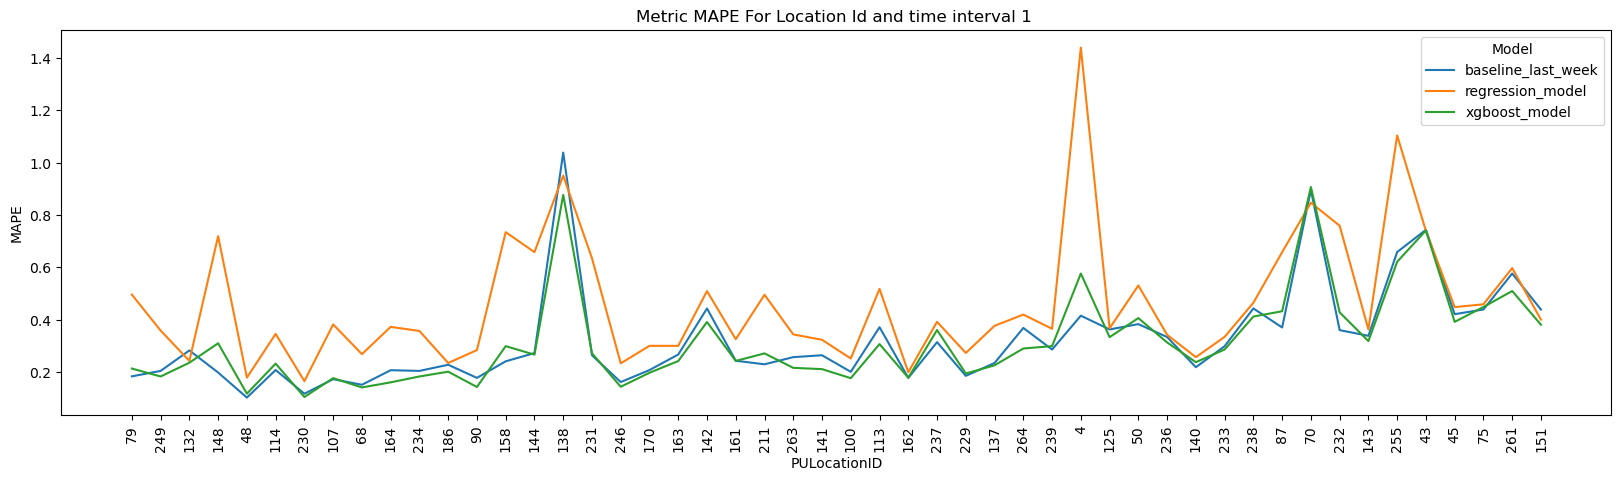

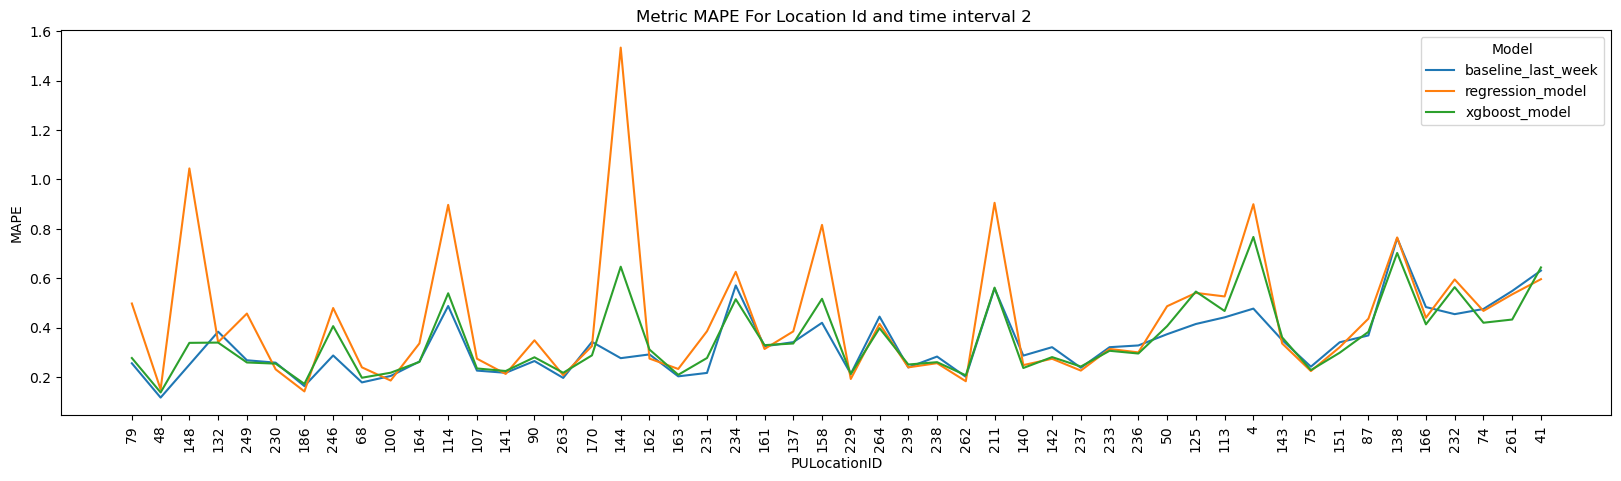

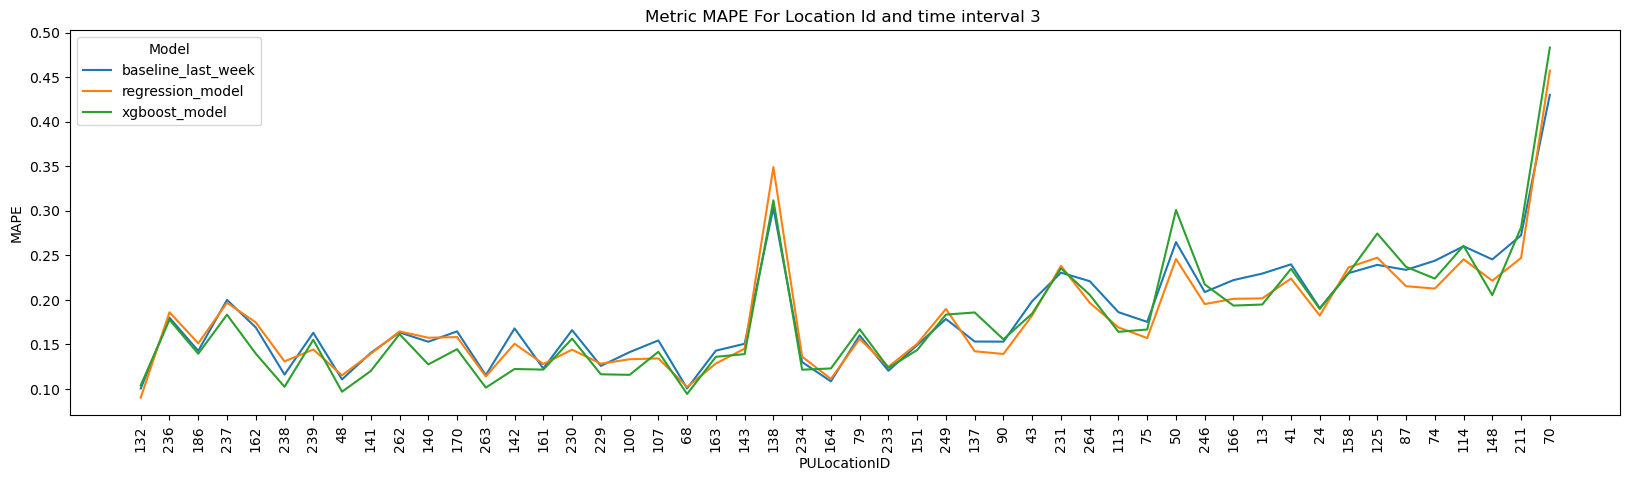

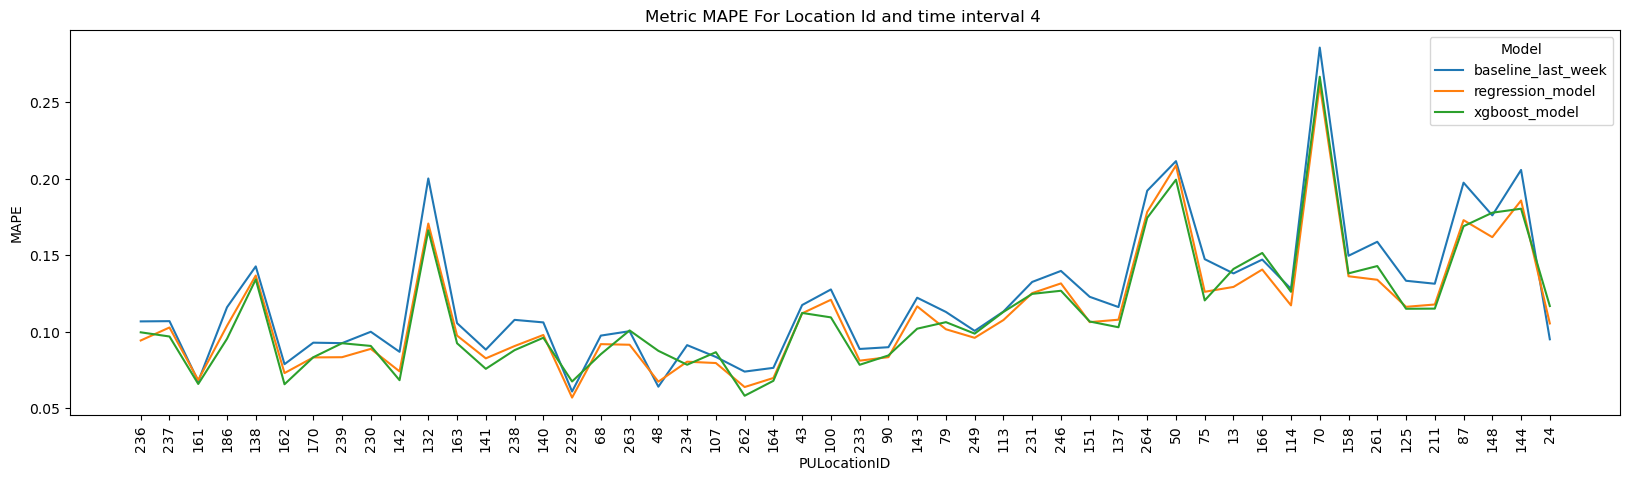

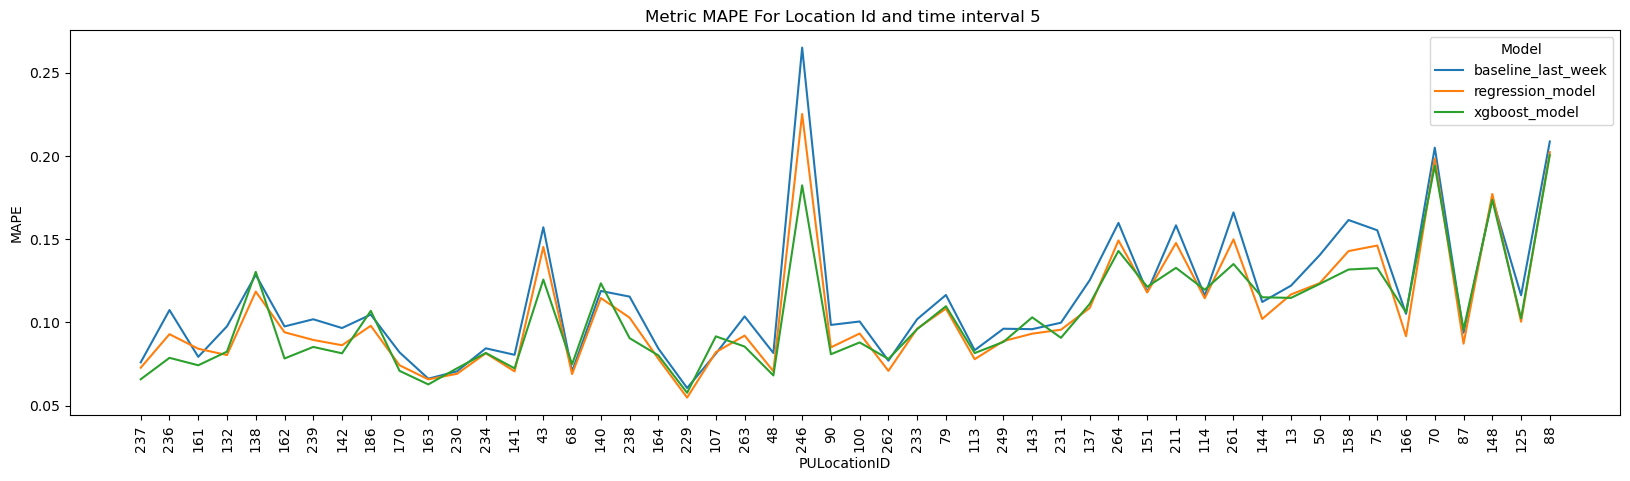

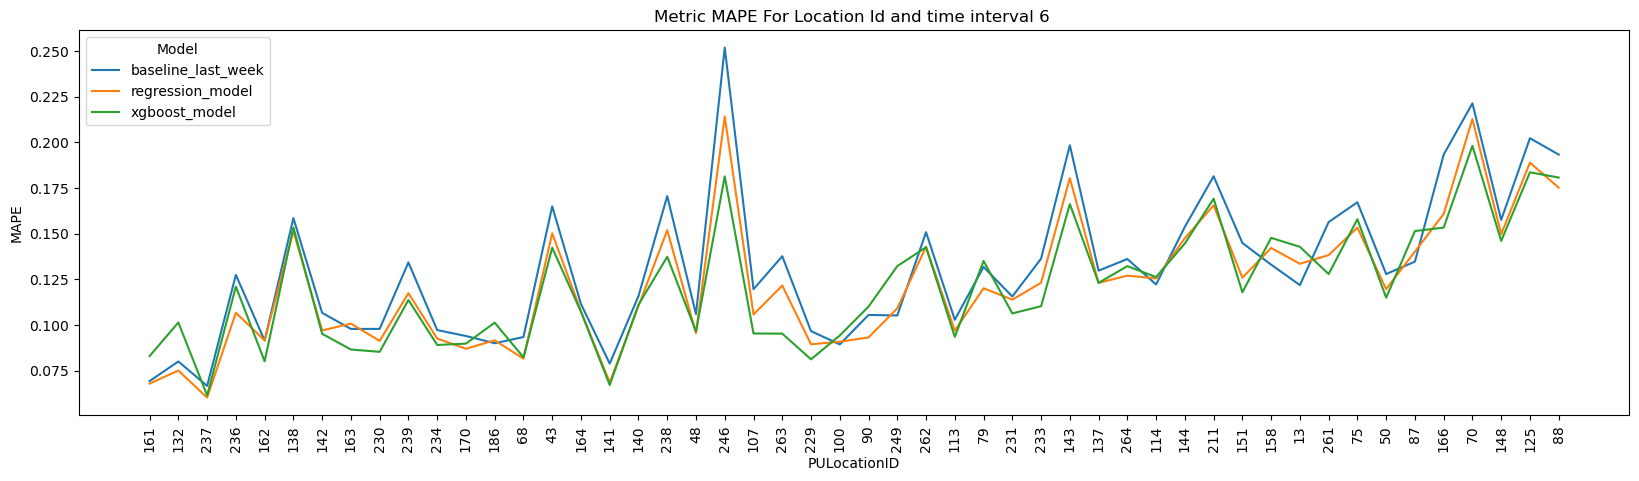

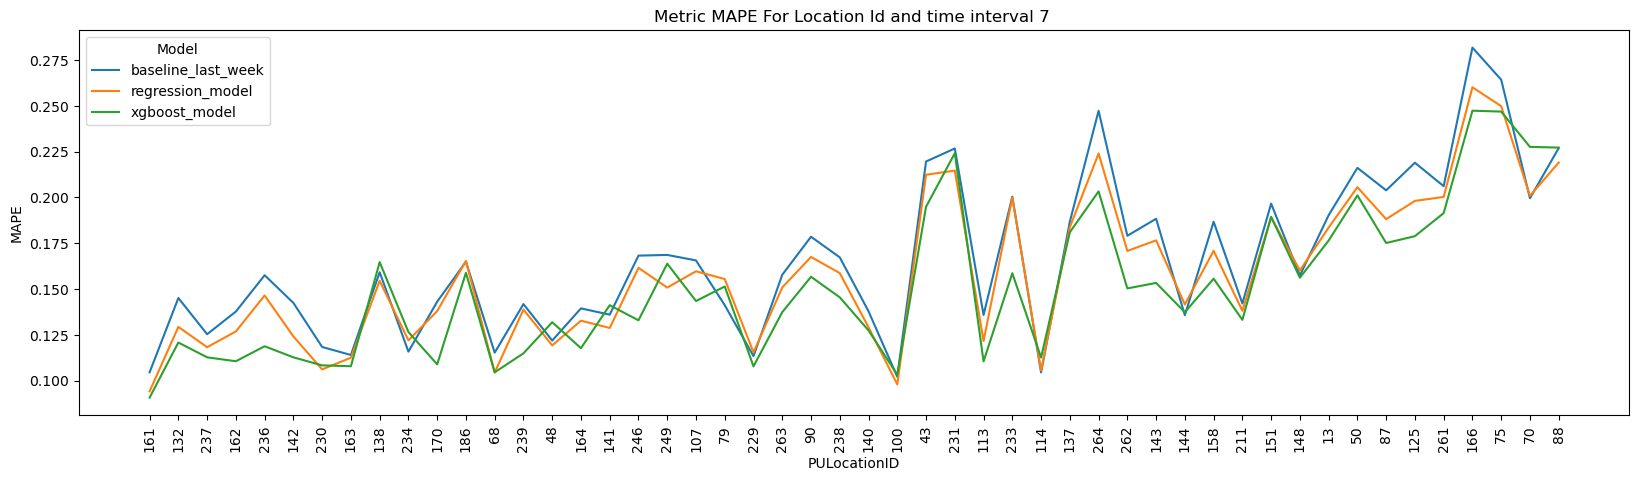

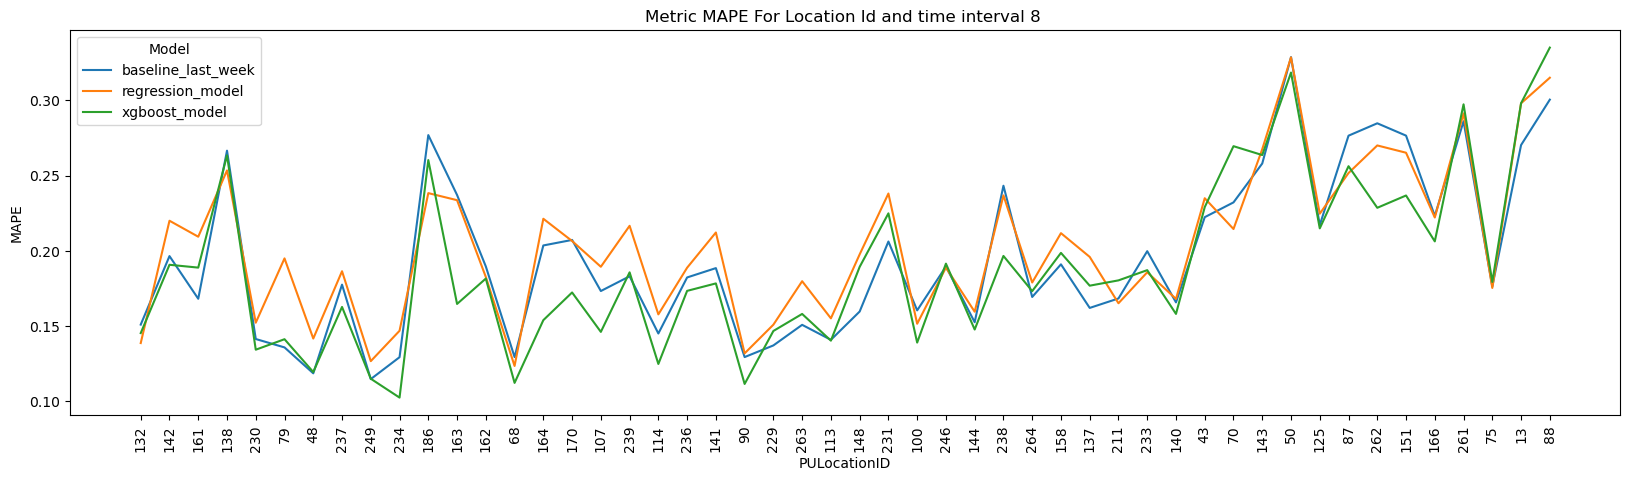

In [221]:
for interval in range(1, 9):
    plot_model_metric(
        xgb_rides_df_sorted[interval],
        PULocationIDs_Metrics_sorted[interval],
        0,
        50,
        'MAPE',
        interval
    )

### Mid Demand

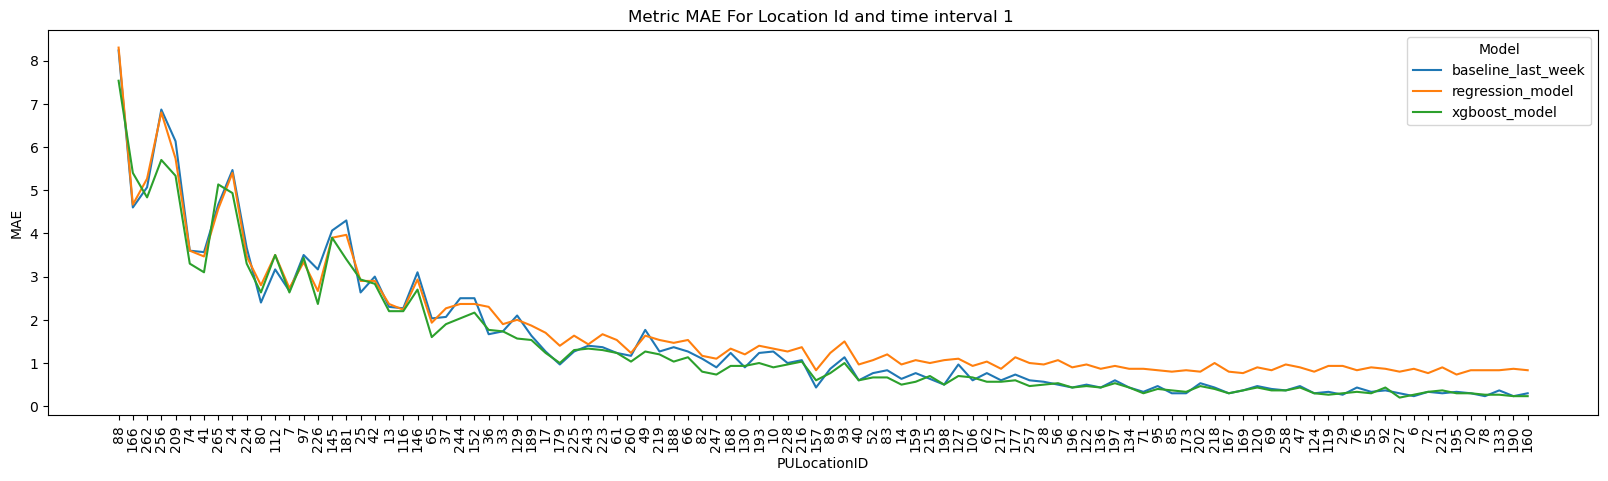

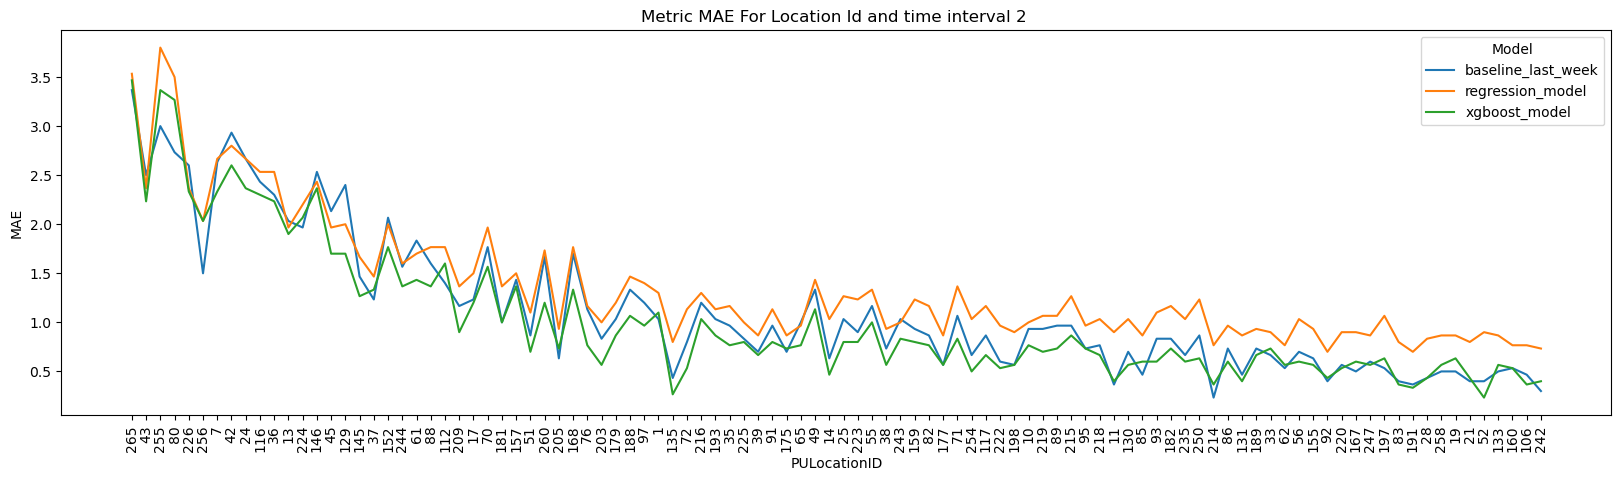

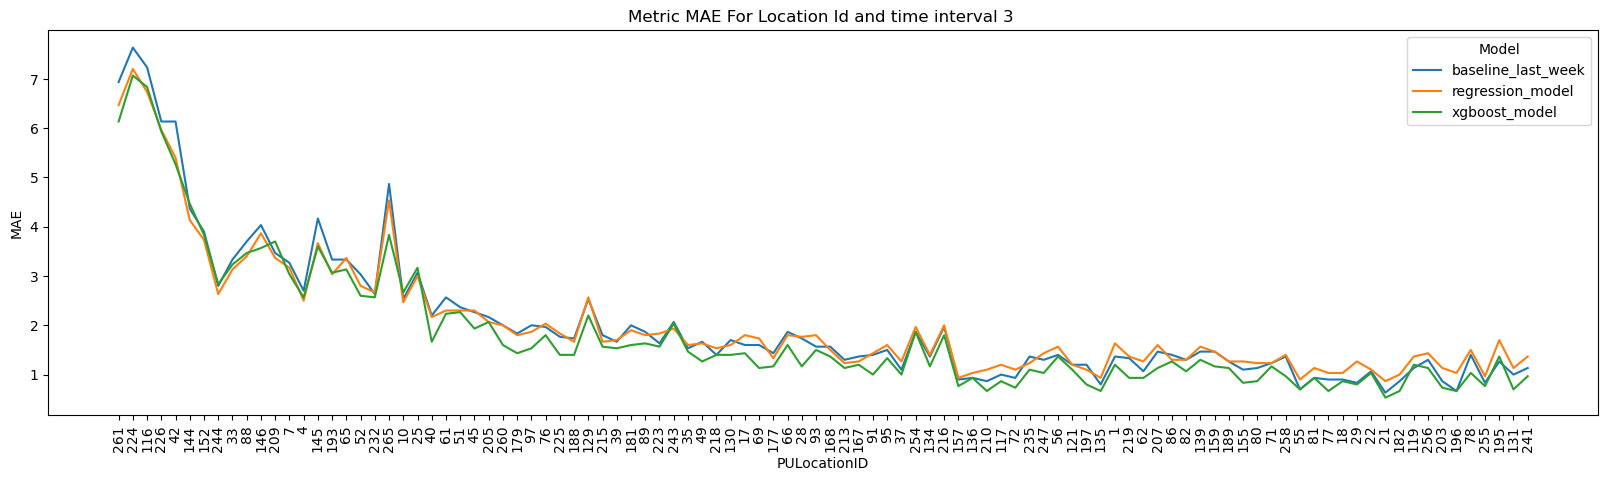

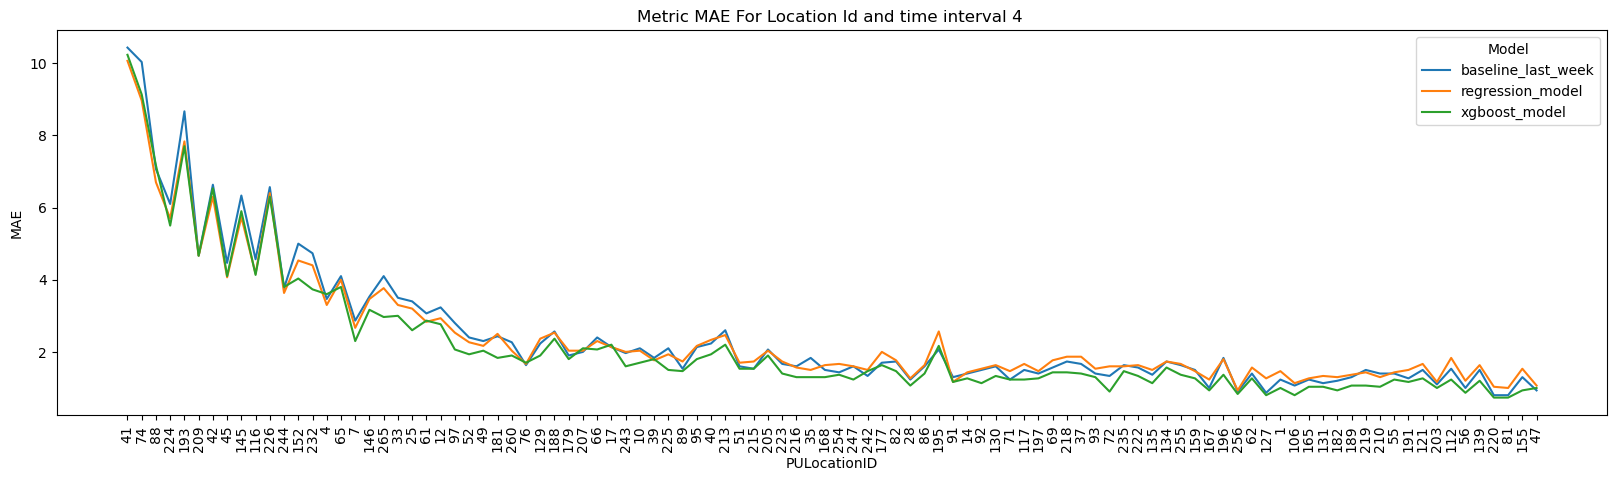

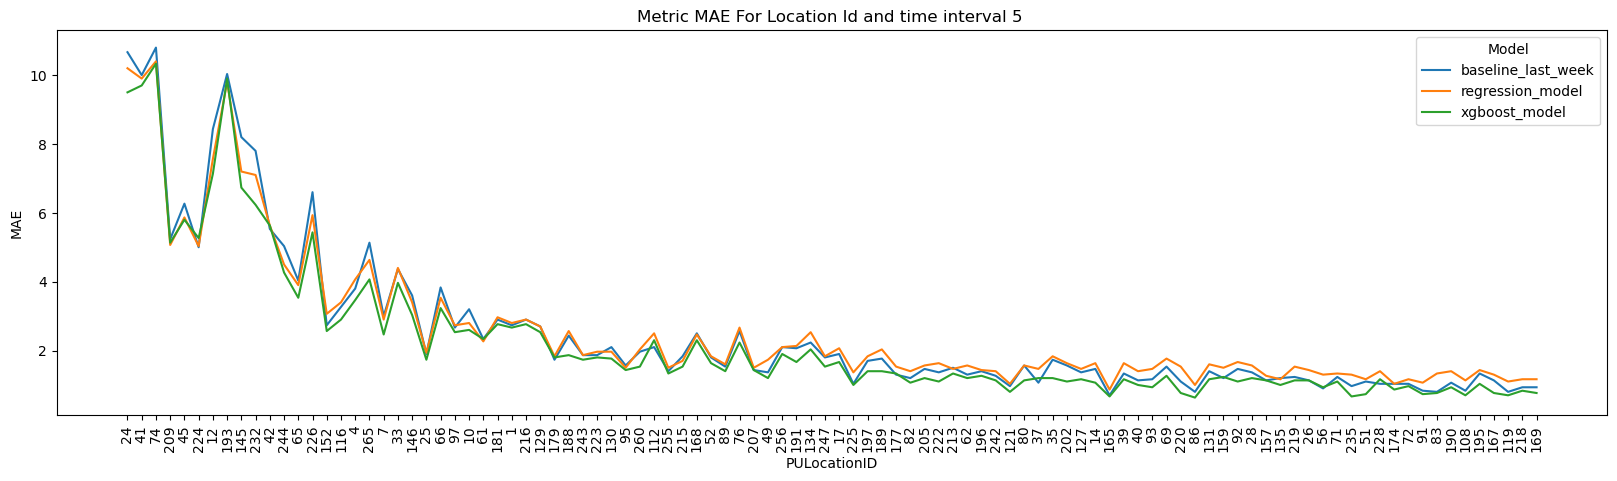

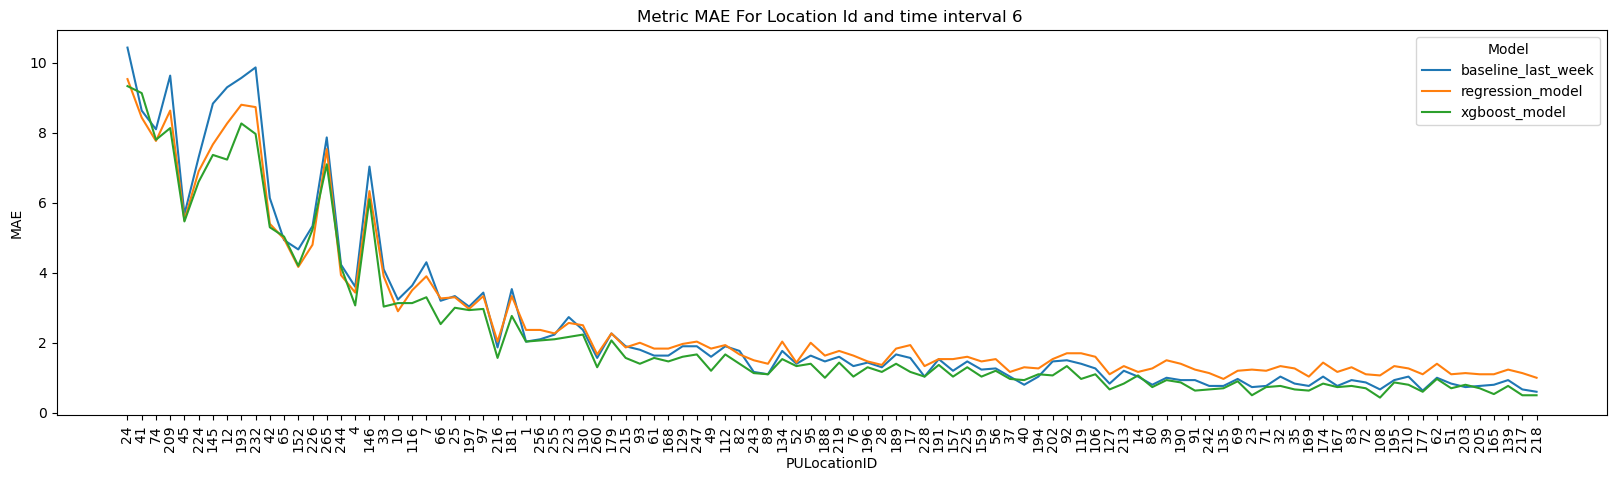

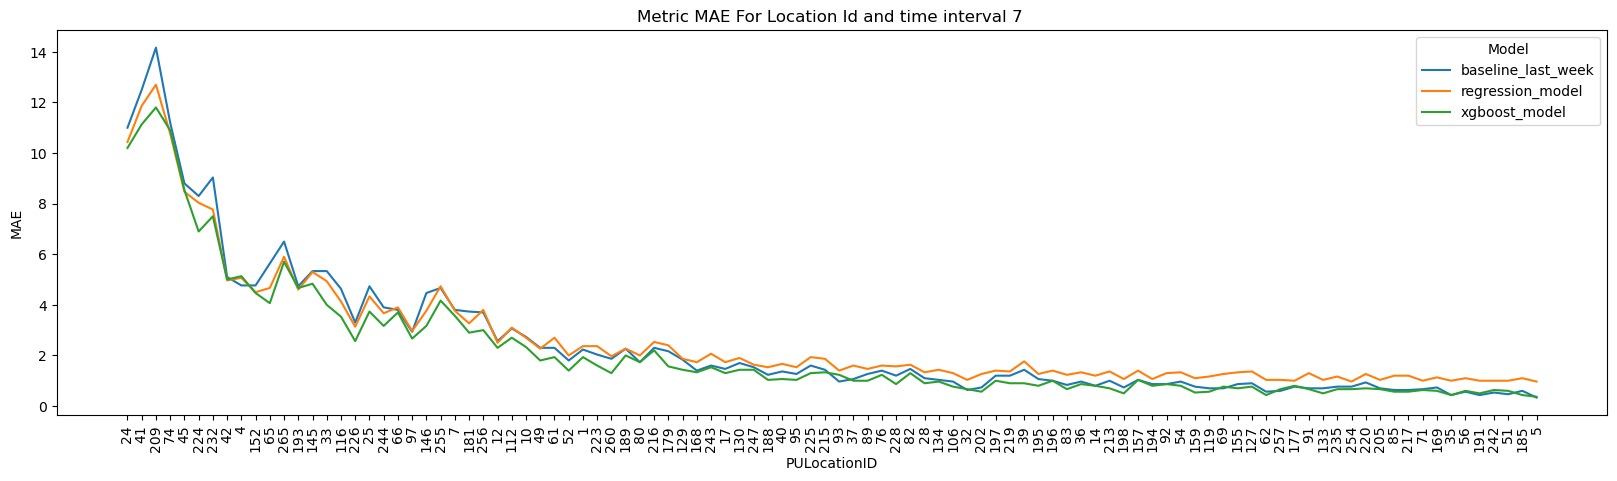

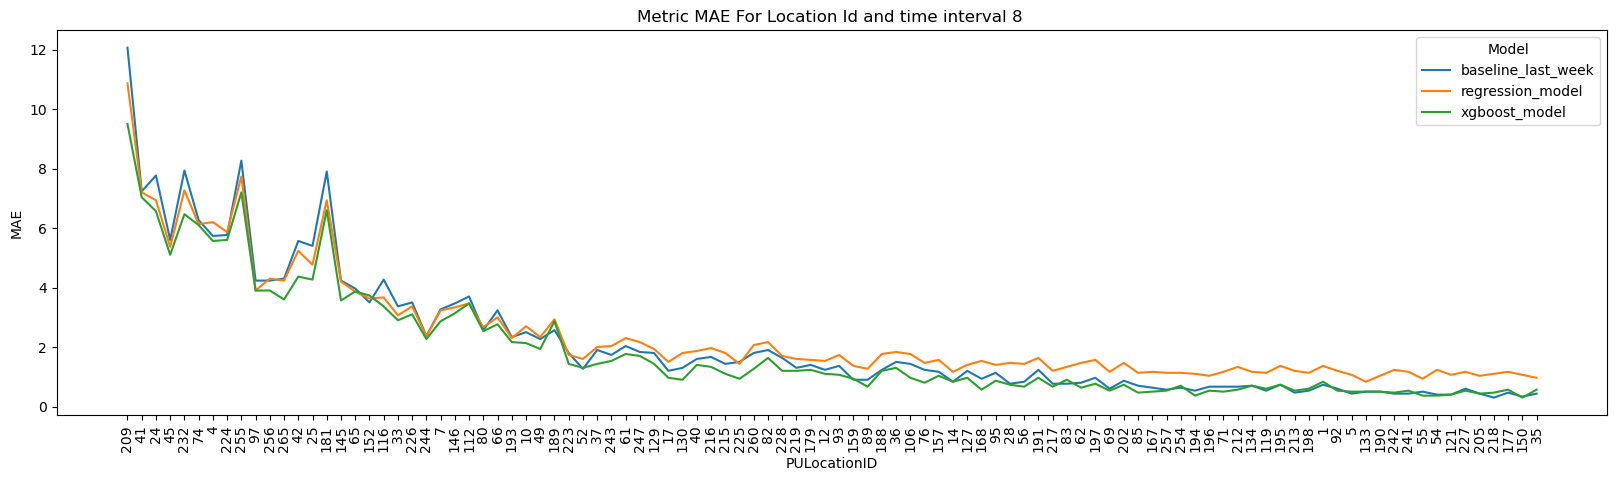

In [222]:
for interval in range(1, 9):
    plot_model_metric(
        xgb_rides_df_sorted[interval],
        PULocationIDs_Metrics_sorted[interval],
        50,
        150,
        'MAE',
        interval
    )

### Low Demand

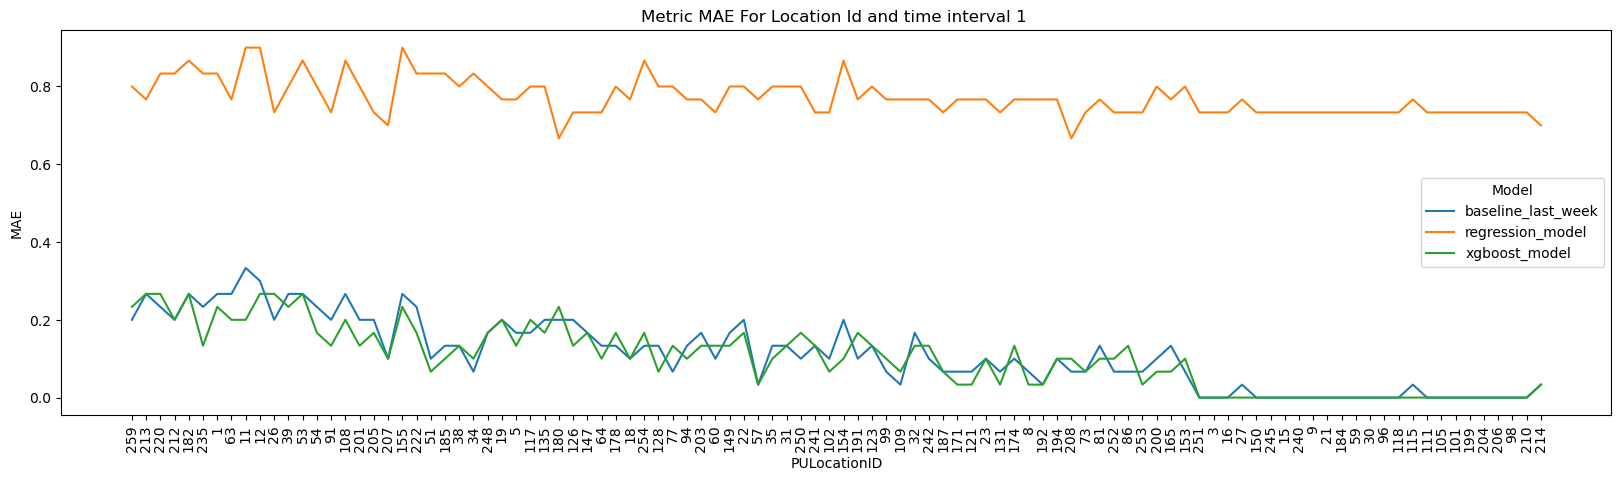

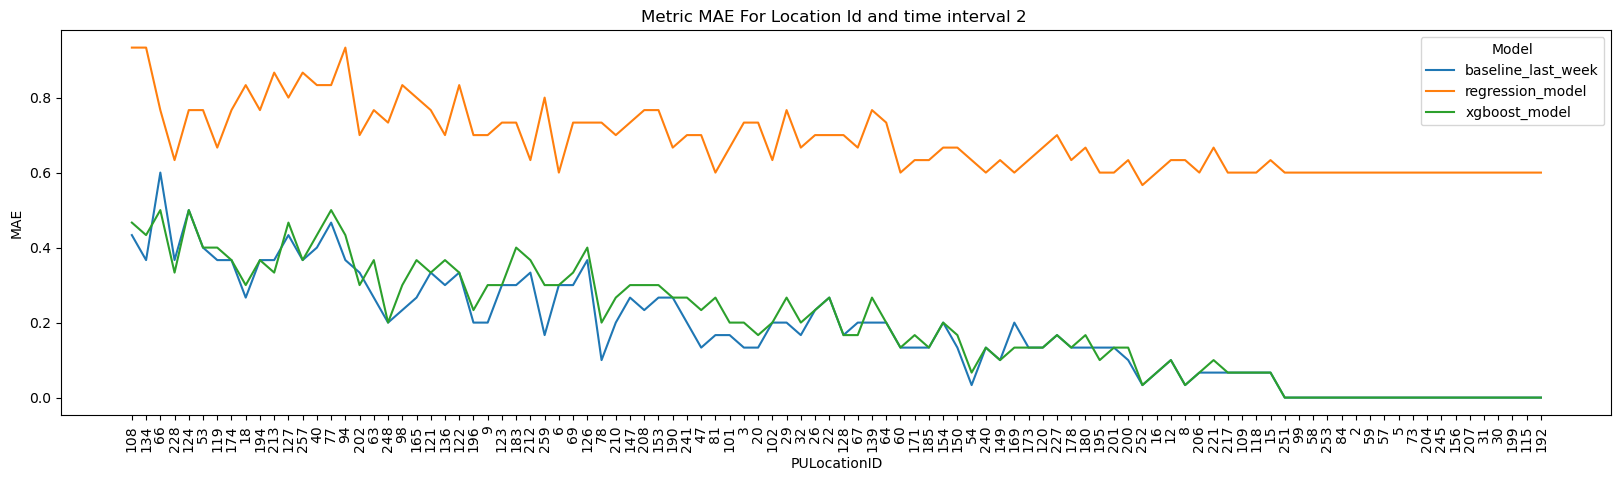

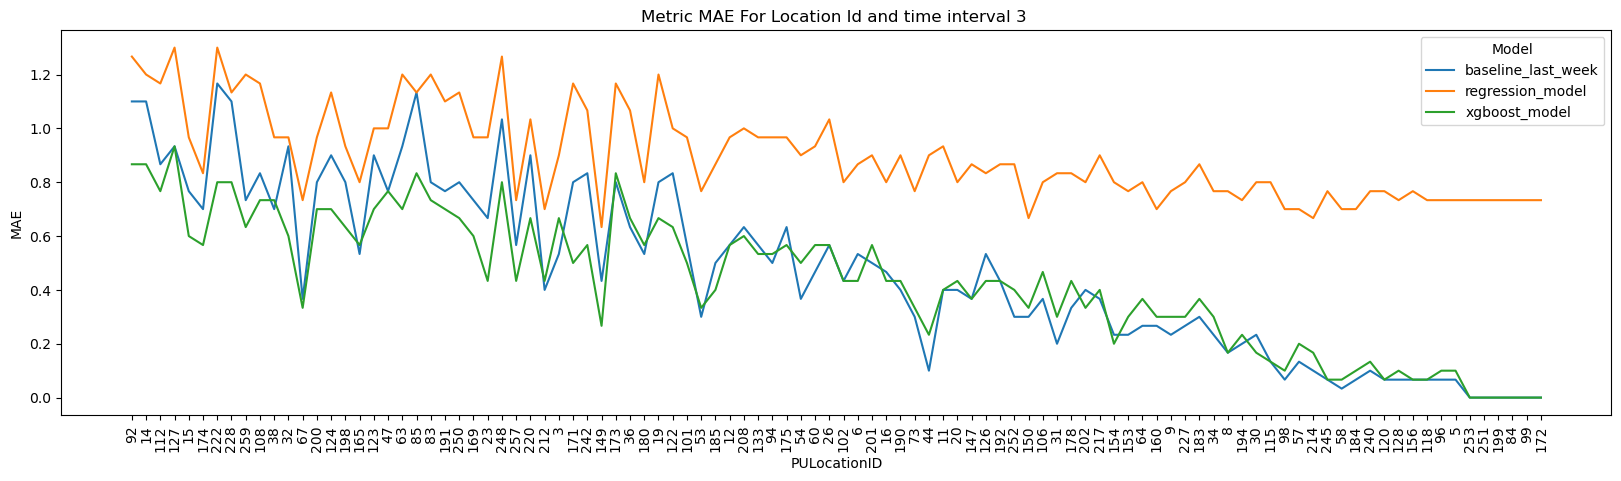

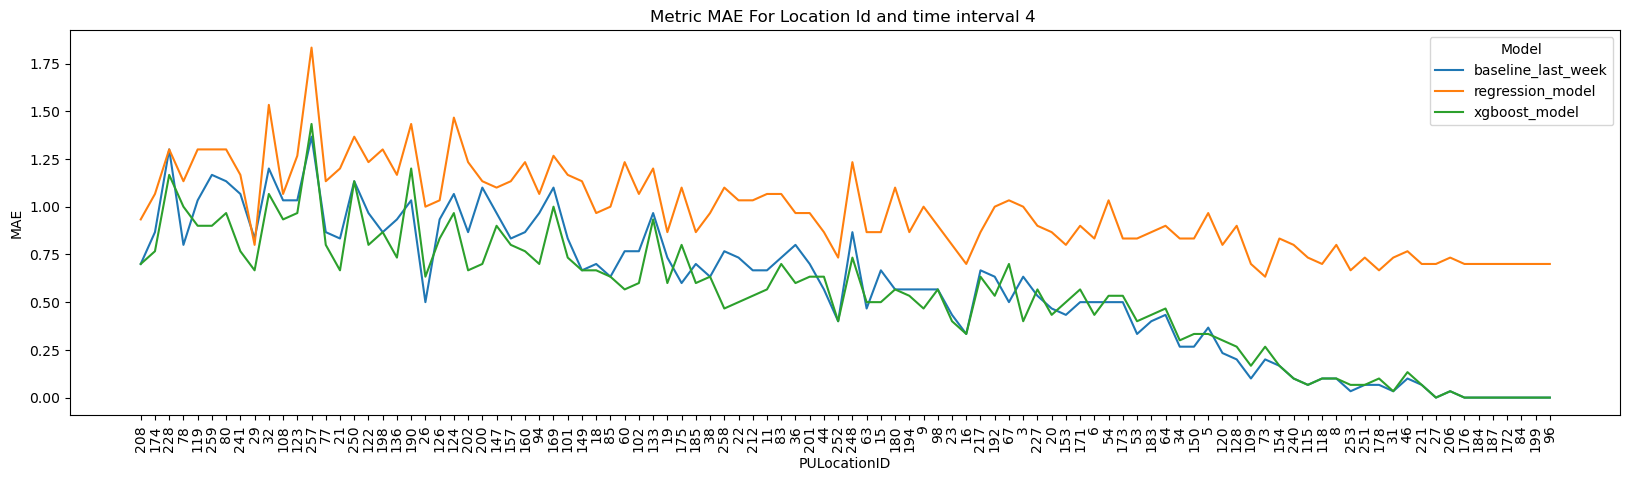

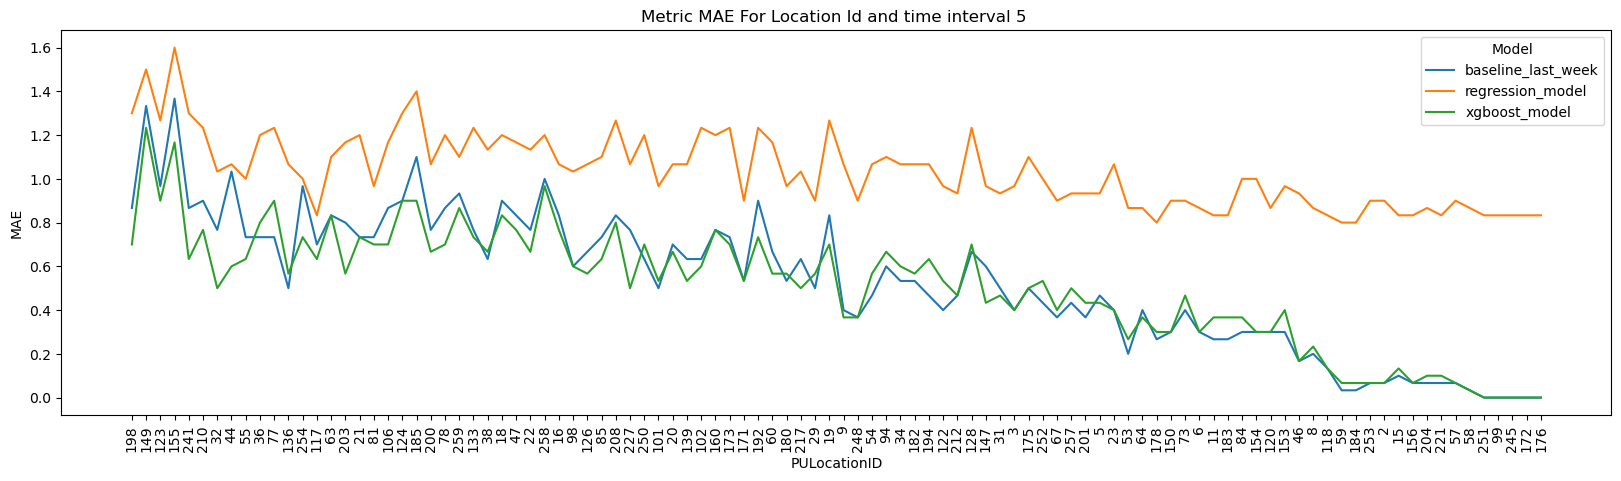

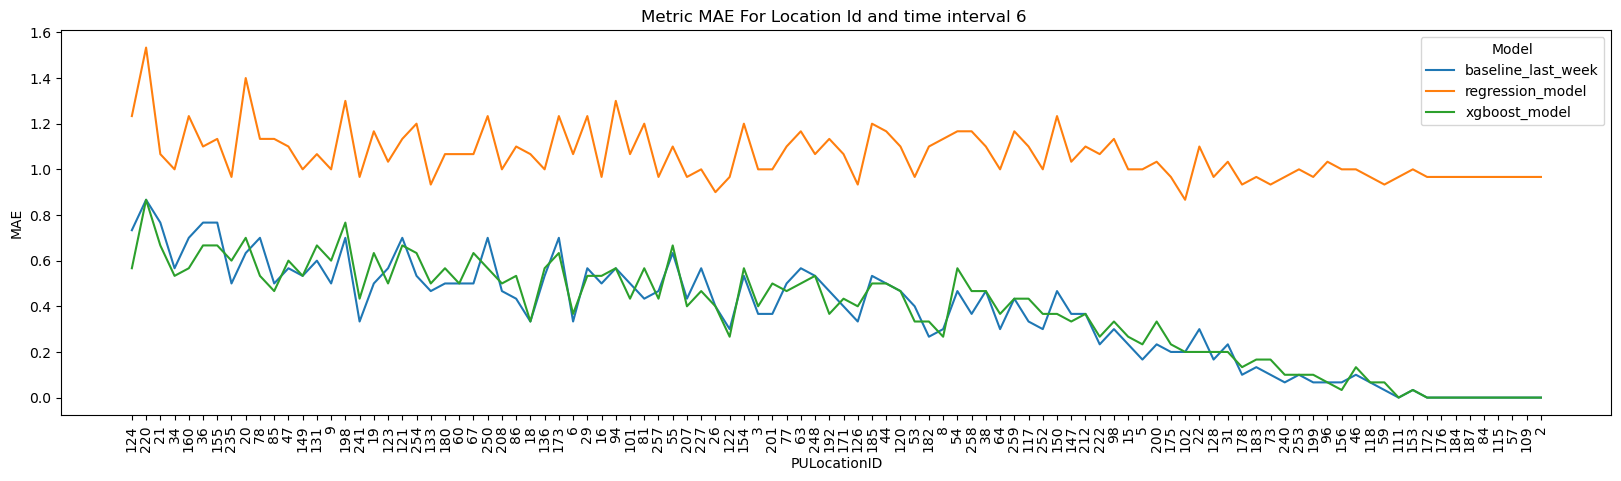

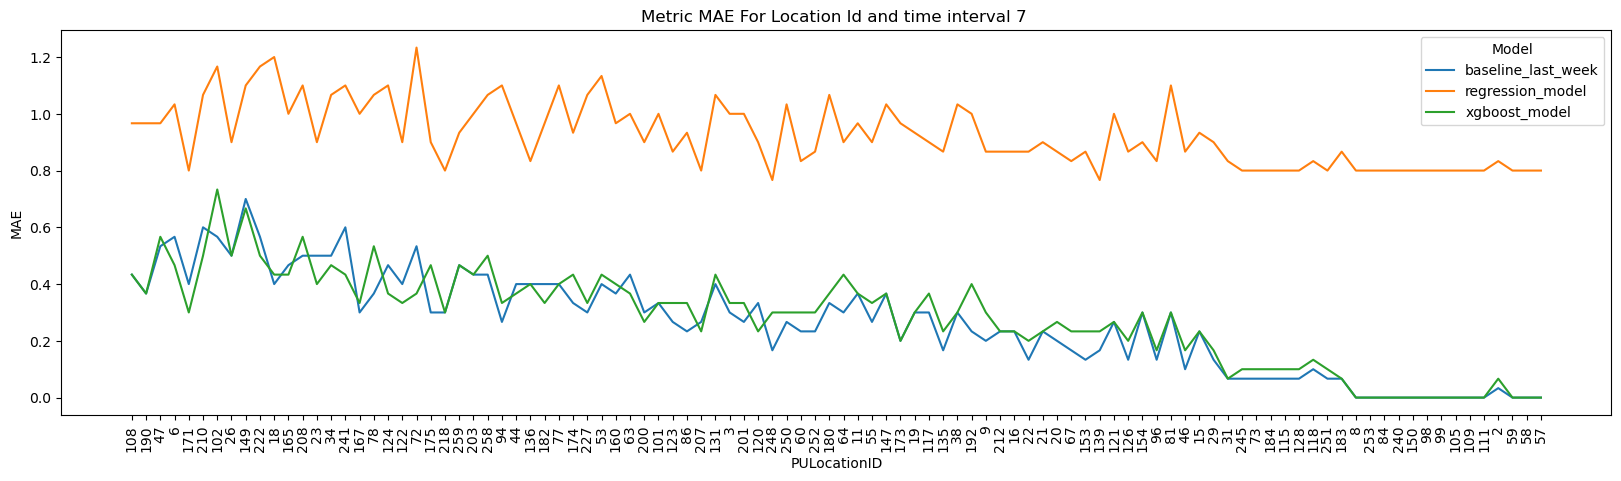

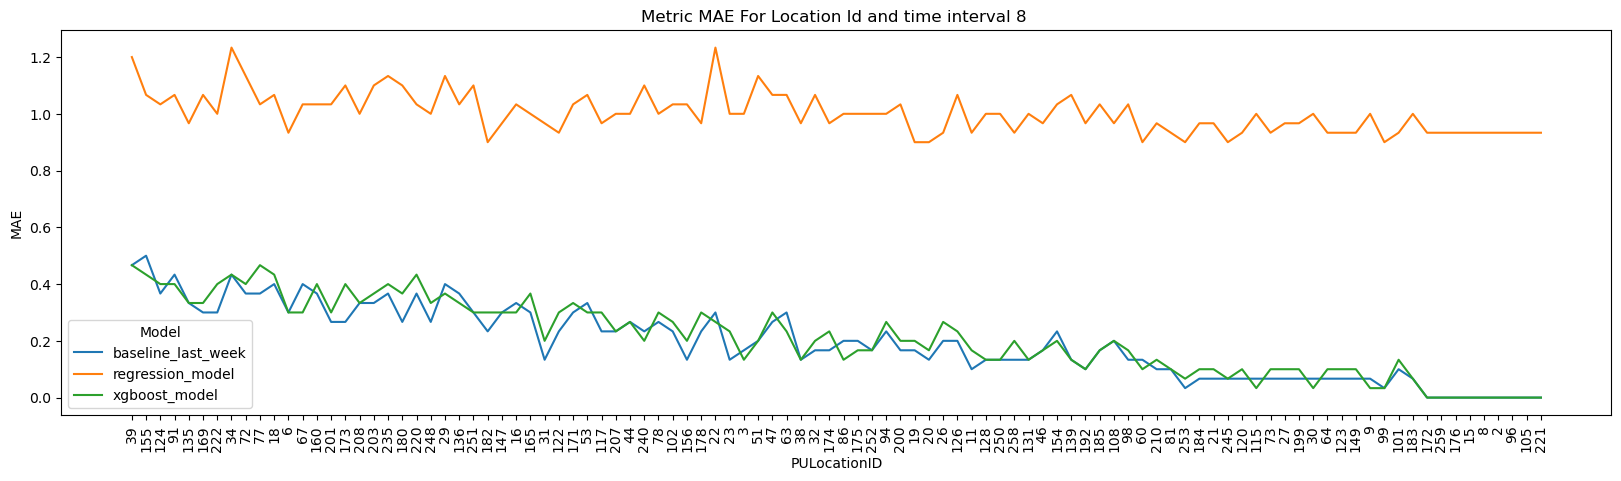

In [223]:
for interval in range(1, 9):
    plot_model_metric(
        xgb_rides_df_sorted[interval],
        PULocationIDs_Metrics_sorted[interval],
        150,
        250,
        'MAE',
        interval
    )

## Compare Models prediction vs. Last day count based on actual count

In [224]:
def plot_model_actual(actual_data, pred_dict, interval, lower_bound = 0, upper_bound = 262):
    selected_df_model = actual_data.groupby('PULocationID')[['real demand']].mean().sort_values(
        'real demand',
        ascending = False
    ).reset_index()

    selected_df_model = selected_df_model.iloc[lower_bound:upper_bound]

    plt.figure(figsize = (18, 5))
    plt.scatter(
        selected_df_model.index,
        selected_df_model['real demand'],
        label = "Actual",
        color = 'red',
        s = 15
    )
    for key in pred_dict:
        sorted_df = pd.merge(
            selected_df_model['PULocationID'],
            pred_dict[key],
            on = 'PULocationID',
            how = 'left'
        )
        sorted_df = sorted_df.groupby('PULocationID')[['predicted demand']].mean().sort_values(
            'predicted demand',
            ascending = False
        ).reset_index()
        plt.plot(
            selected_df_model.index,
            sorted_df['predicted demand'],
            label = key
        )

    plt.xticks(
        selected_df_model.index,
        selected_df_model['PULocationID'],
        rotation = 90
    )

    plt.legend()
    plt.xlabel('PULocationID')
    plt.ylabel('Counts')
    plt.title(f'Demand count compare models predictions vs. actual in time interval {interval}')

    plt.show()

In [225]:
def plot_separated_demand(predictions_dict, xgb_rides_df, lower_bound, upper_bound):
  for interval in range(1, 9):
      temp = {
        'baseline_last_week' : pd.DataFrame(),
        'regression_model' : pd.DataFrame(),
        'xgboost_model' : pd.DataFrame()
      }
      for key in predictions_dict.keys():
        temp[key] = temp[key].append(predictions_dict[key][predictions_dict[key]['time_interval_number'] == interval])
      plot_model_actual(
          xgb_rides_df[xgb_rides_df['time_interval_number'] == interval],
          temp,
          interval,
          lower_bound,
          upper_bound
      )

### High Demand

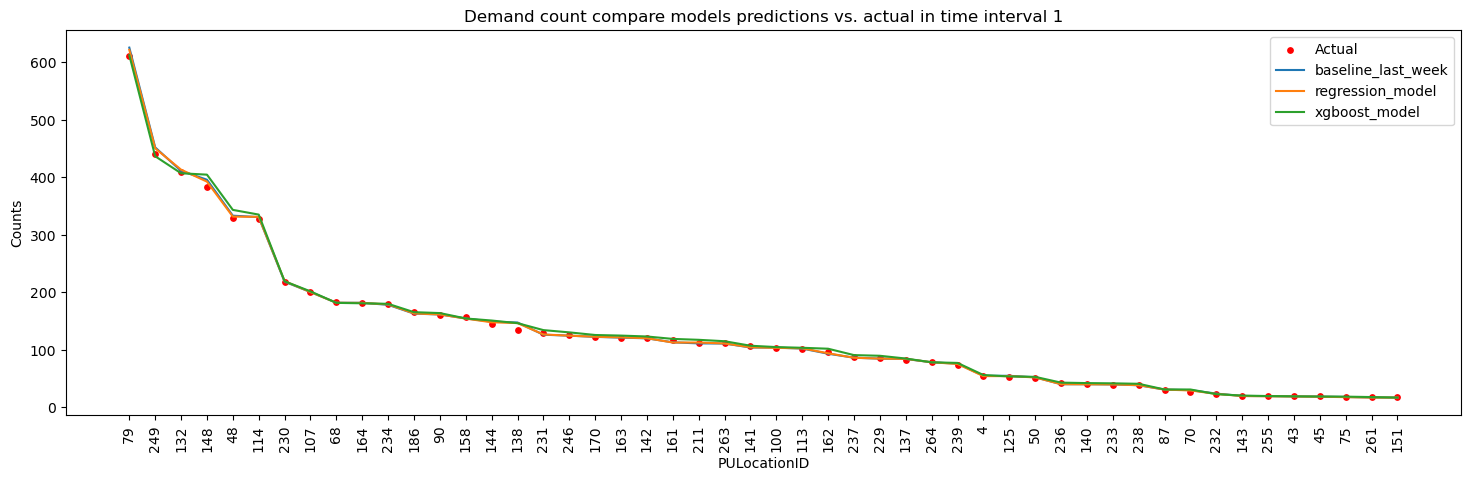

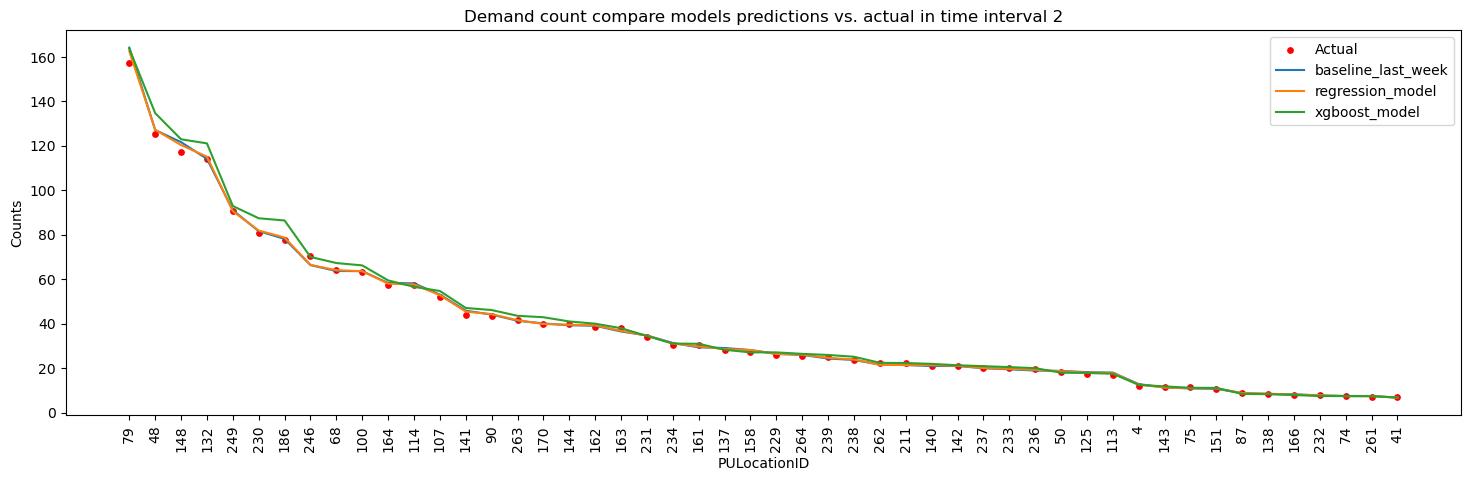

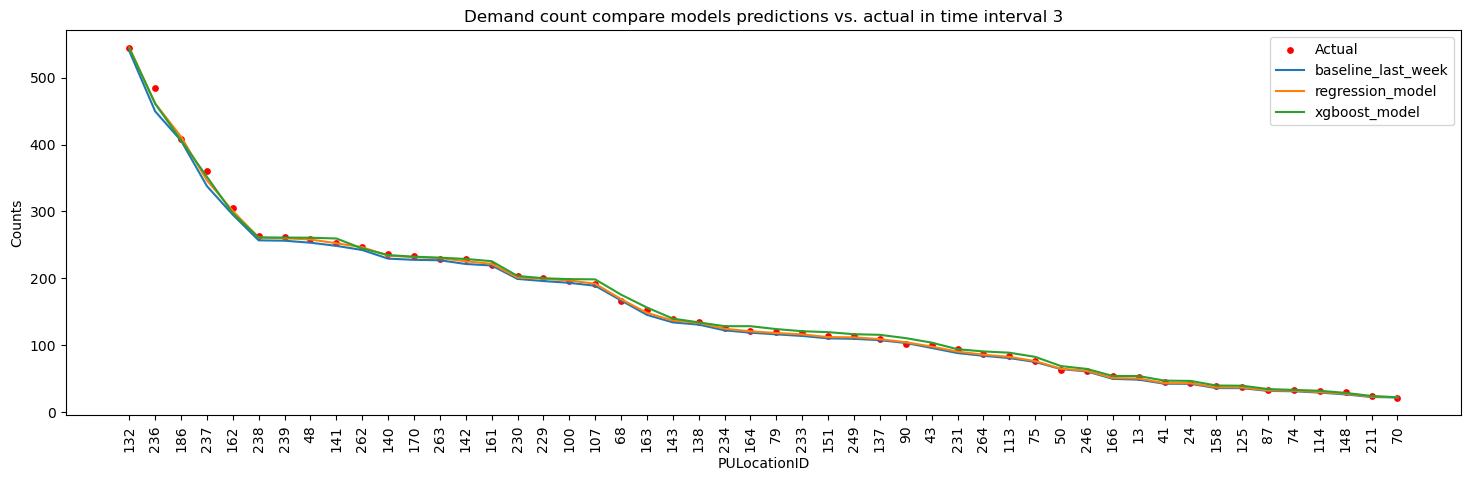

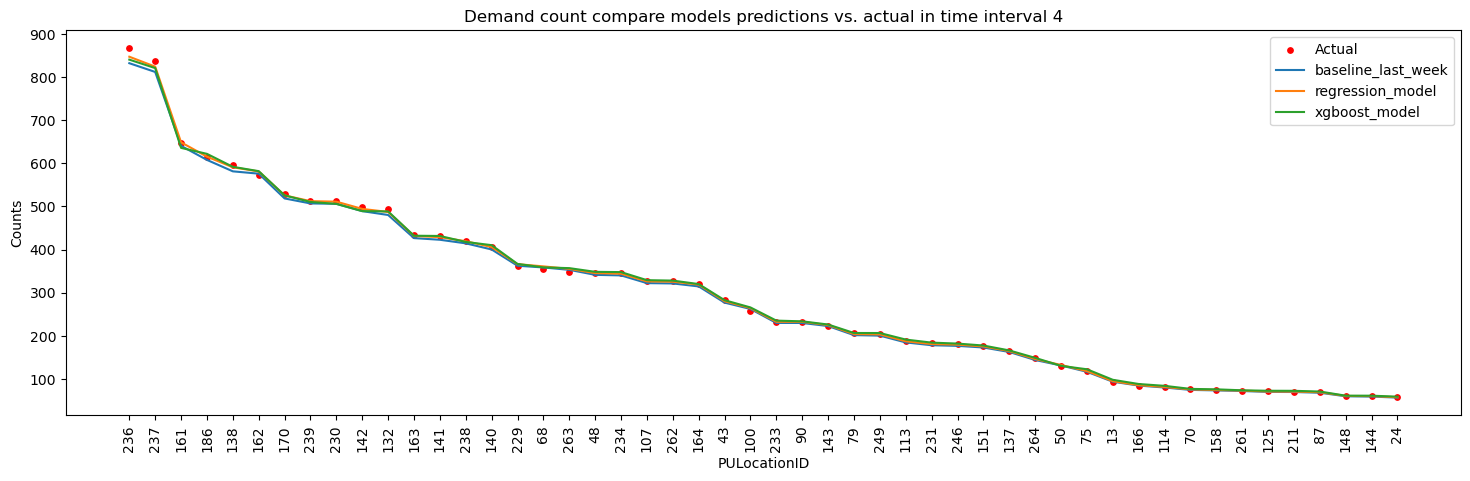

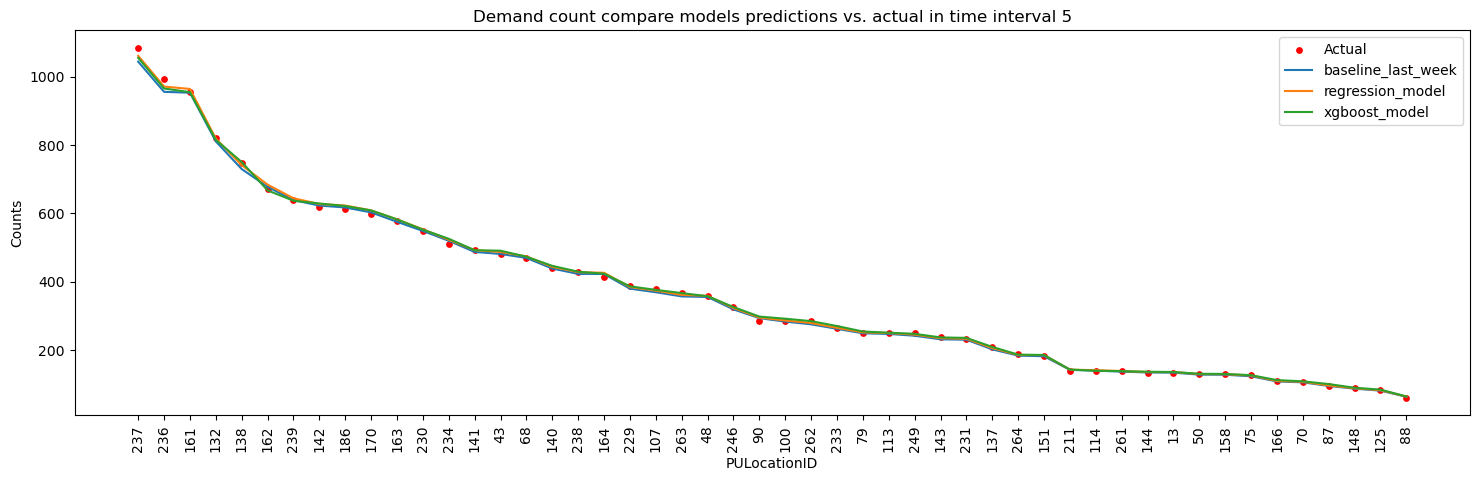

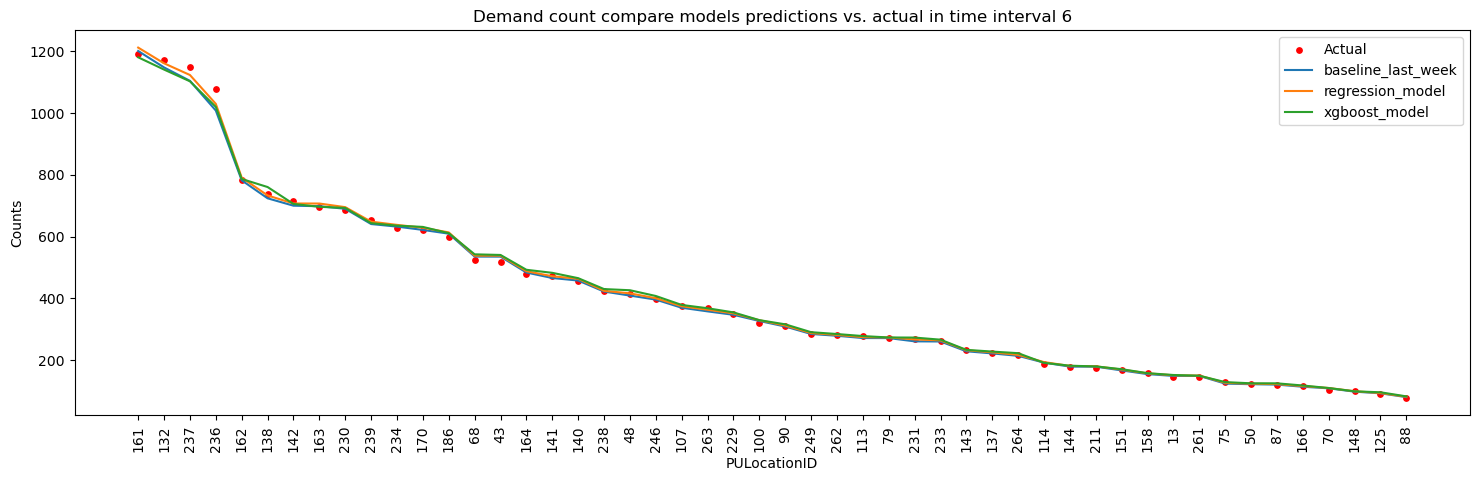

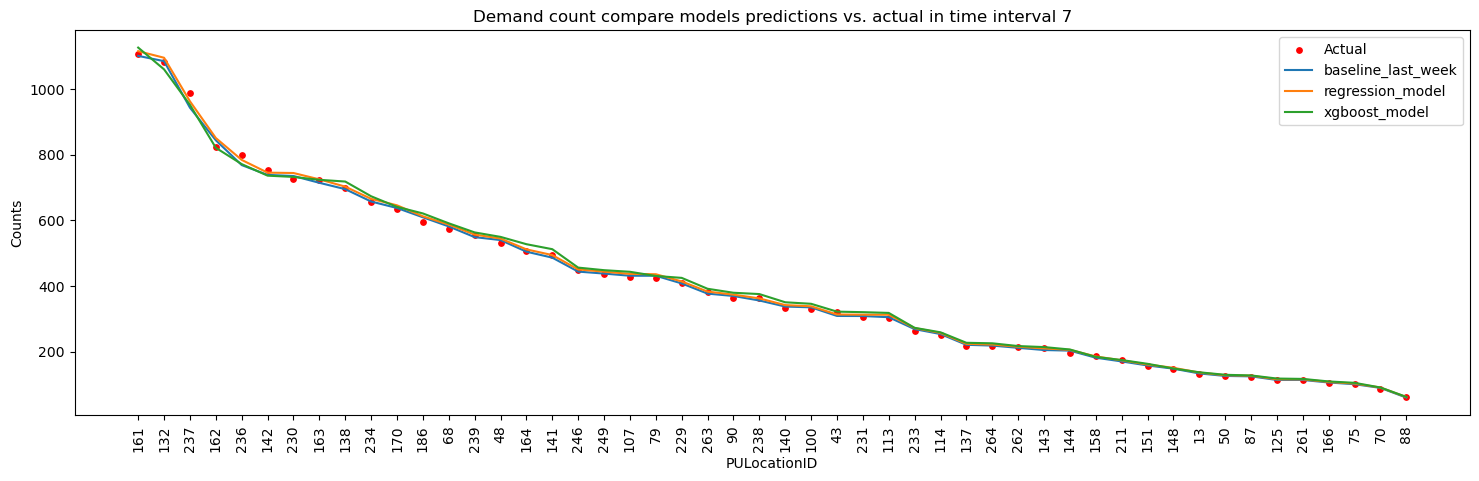

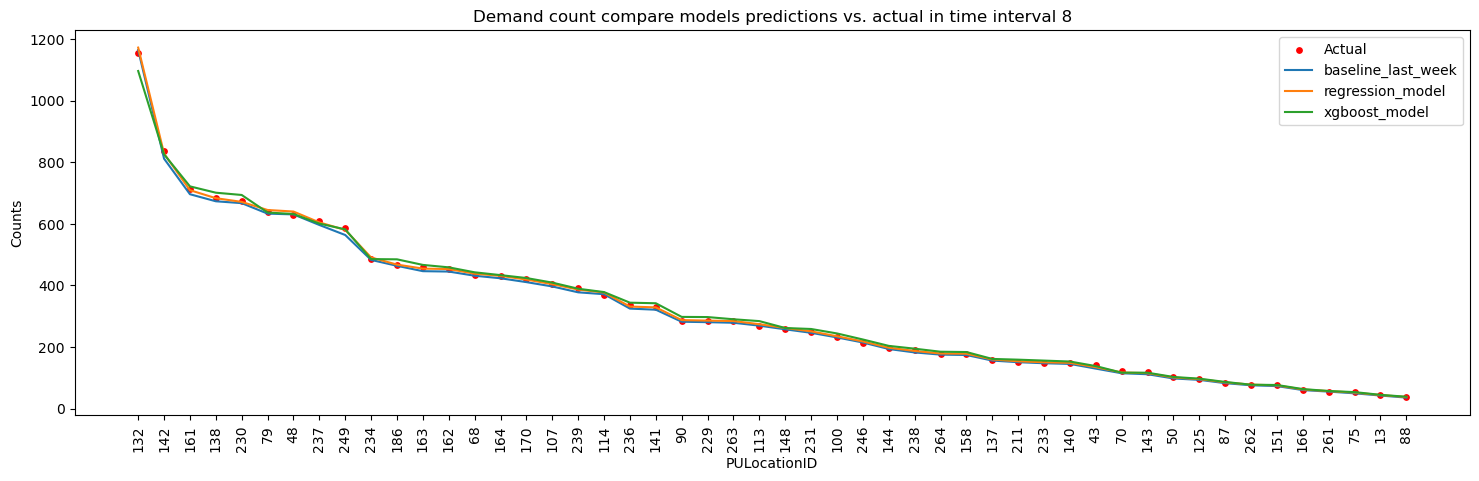

In [226]:
plot_separated_demand(predictions_dict, xgb_rides_df, 0, 50)

### Mid Demand

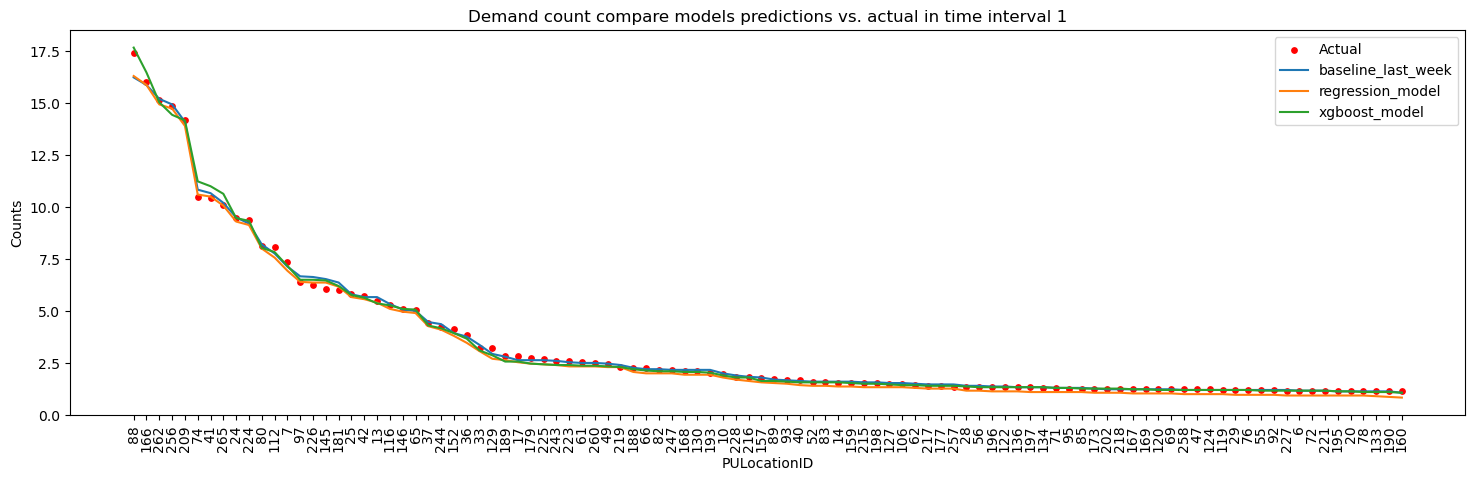

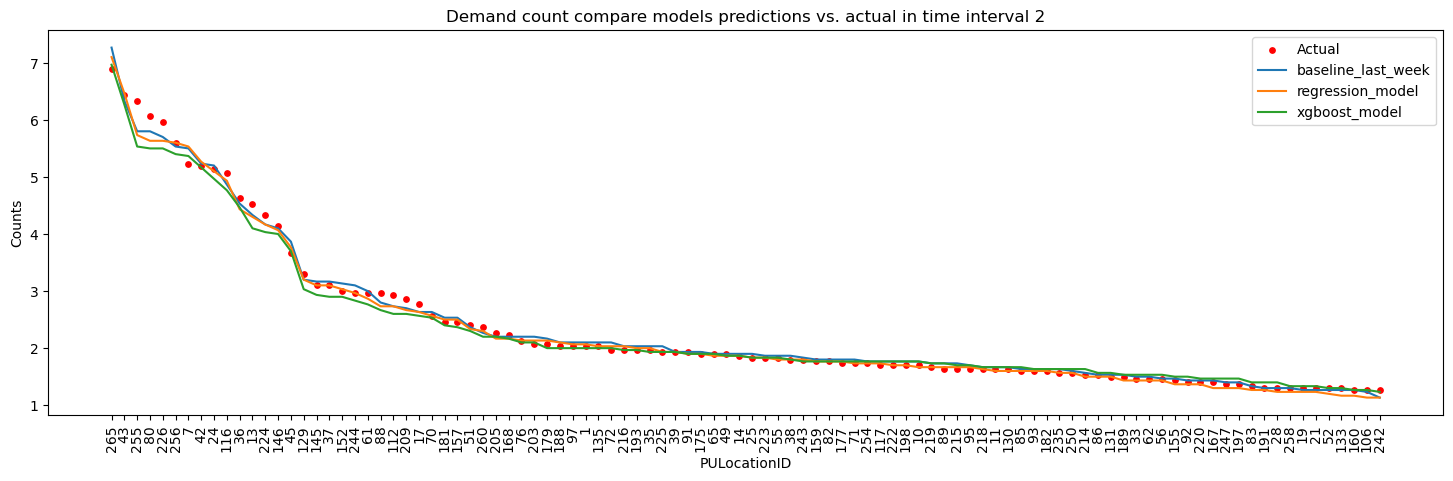

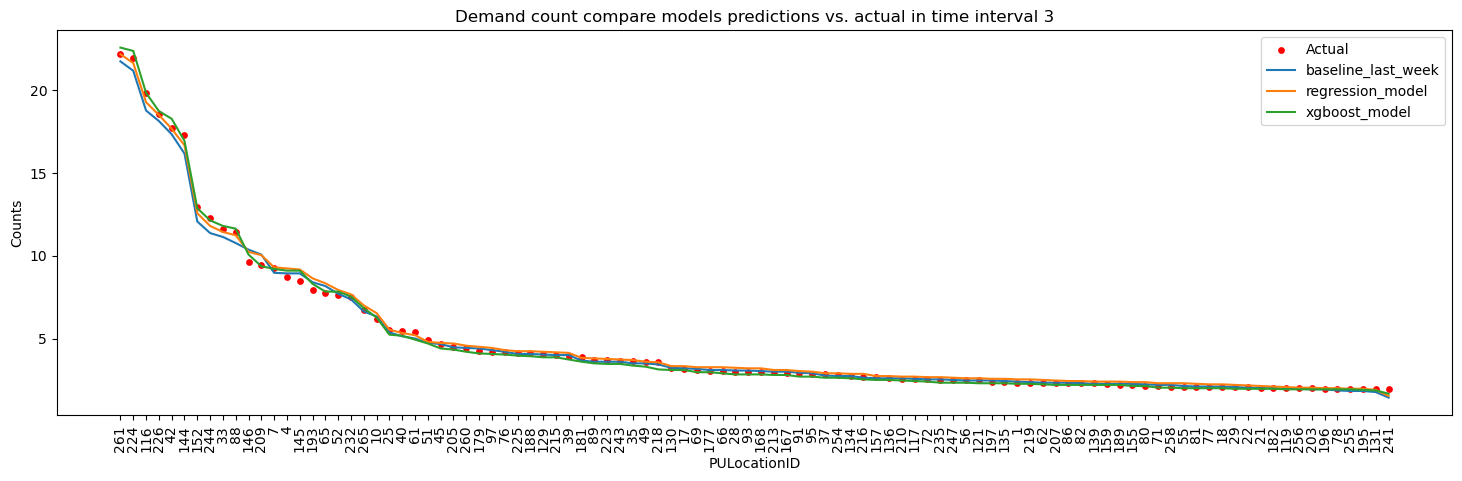

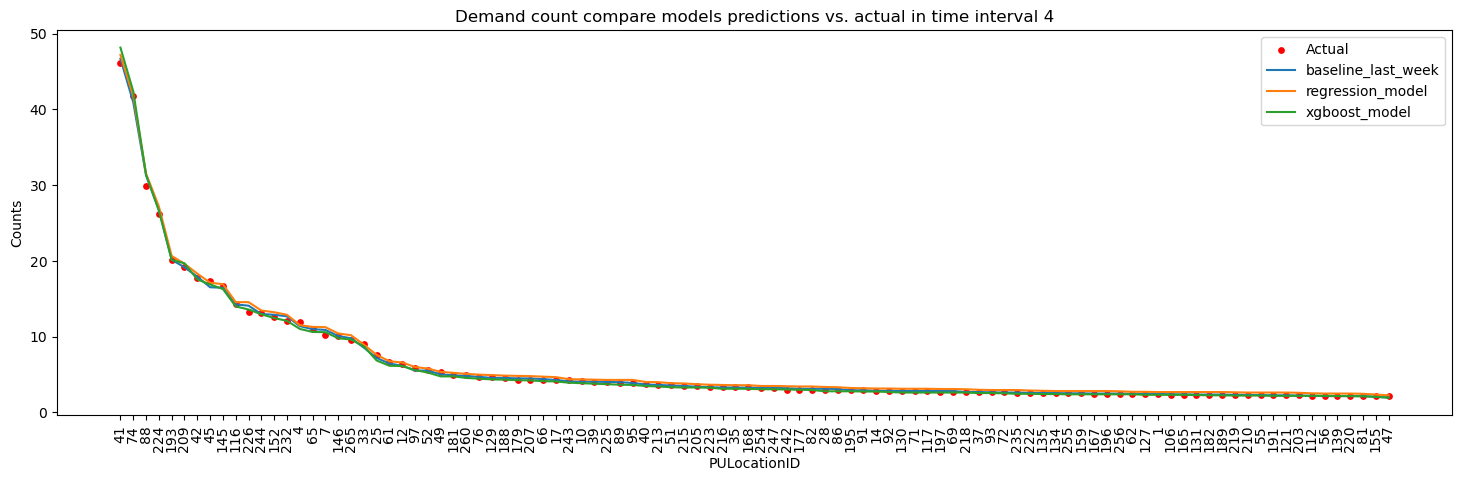

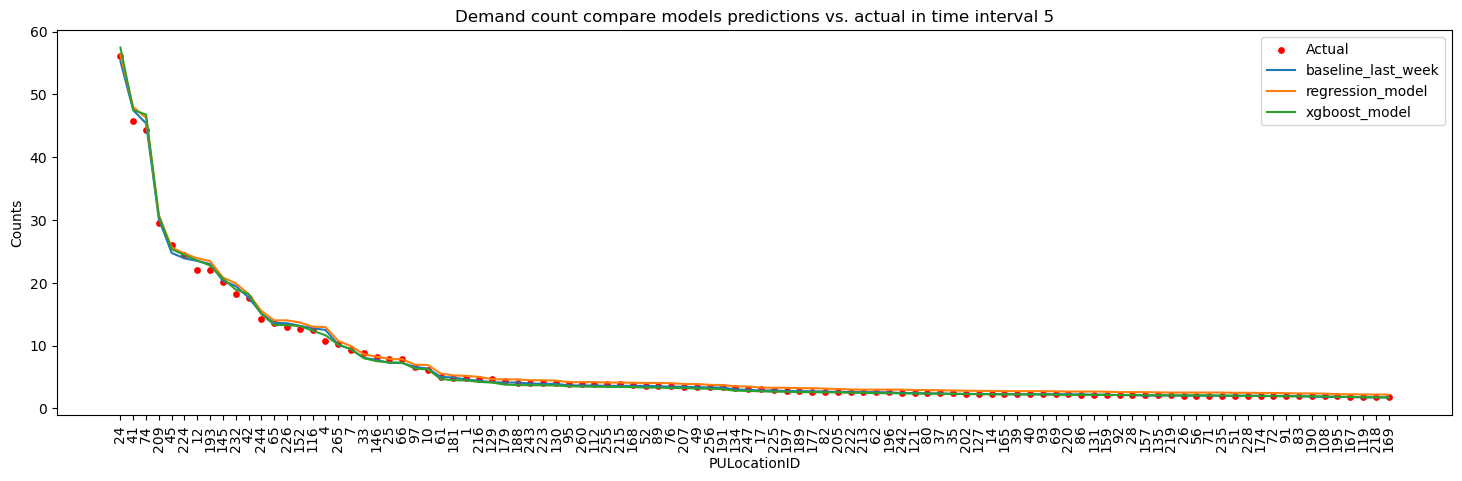

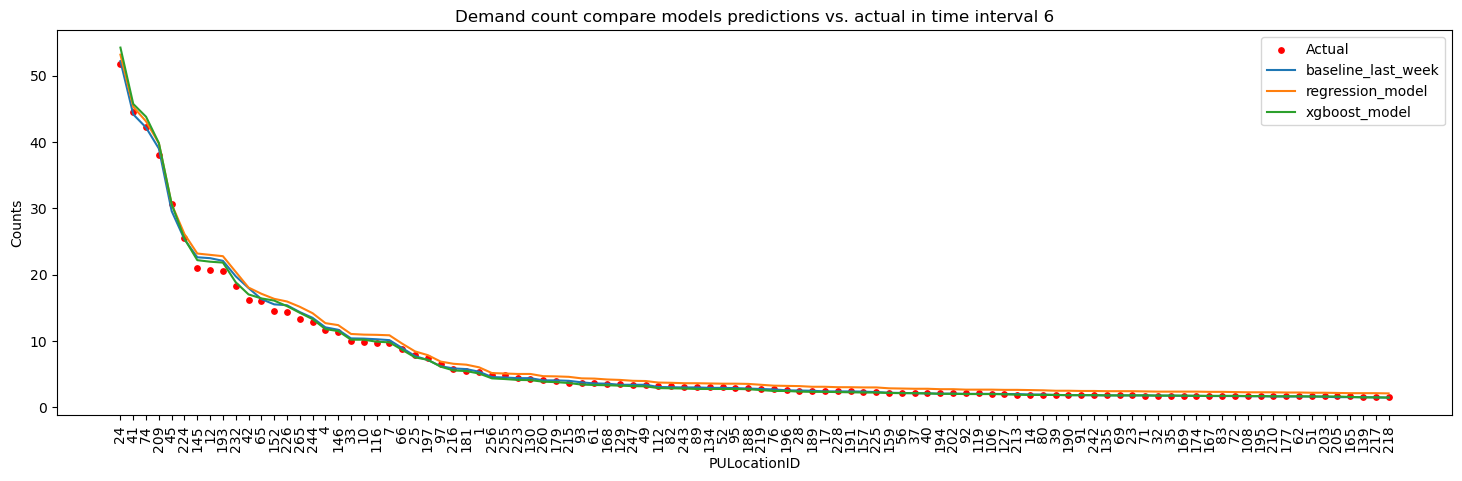

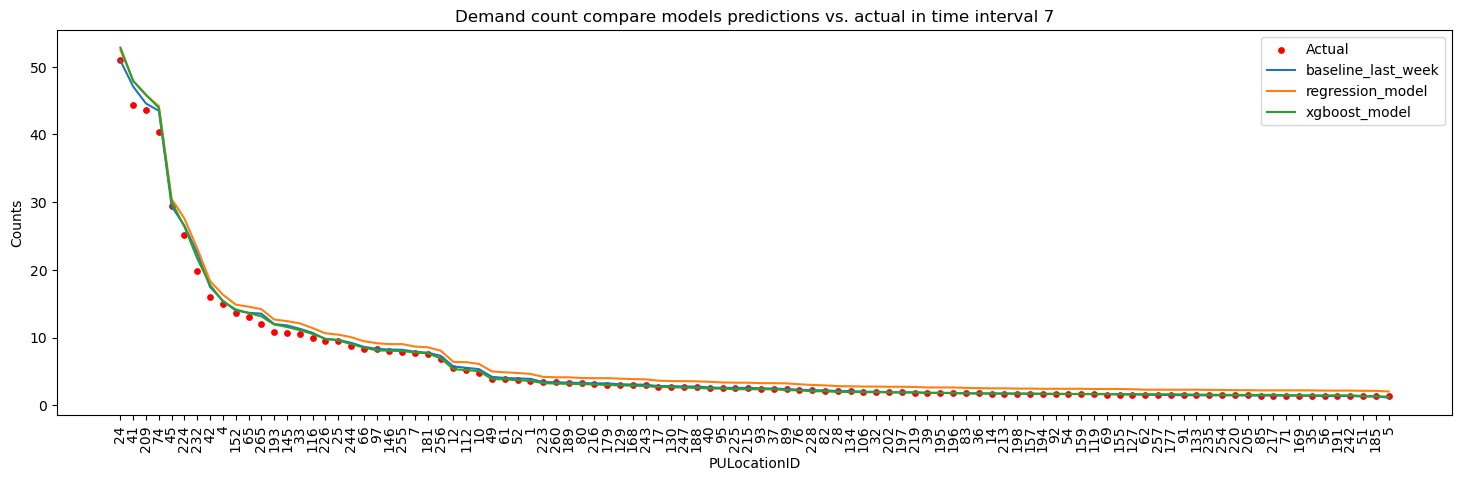

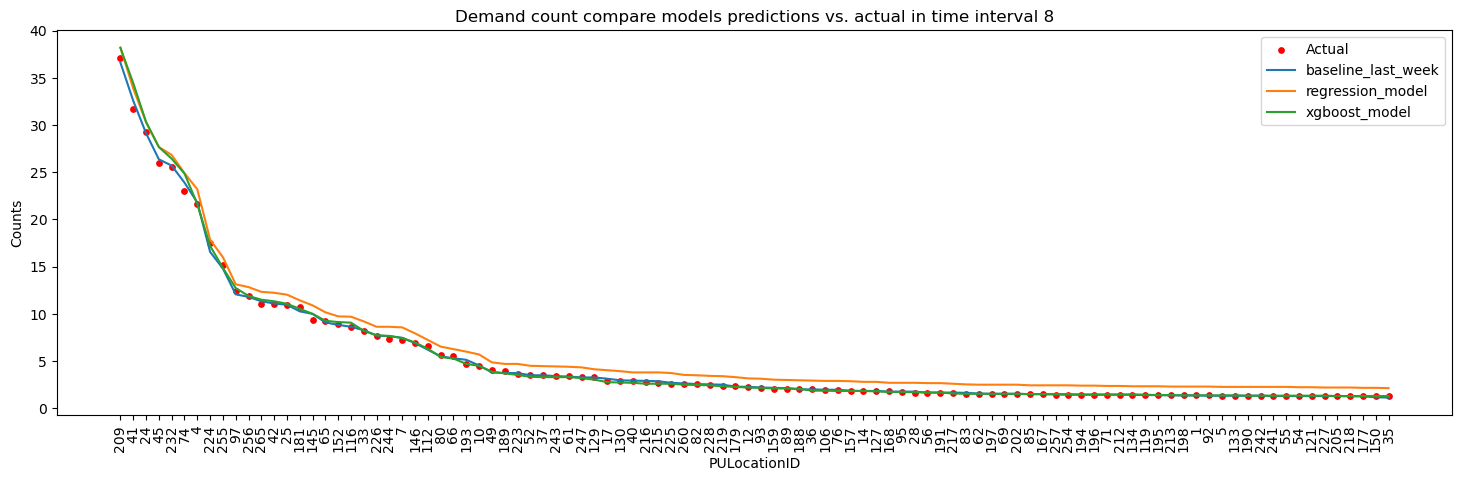

In [227]:
plot_separated_demand(predictions_dict, xgb_rides_df, 50, 150)

### Low Demand

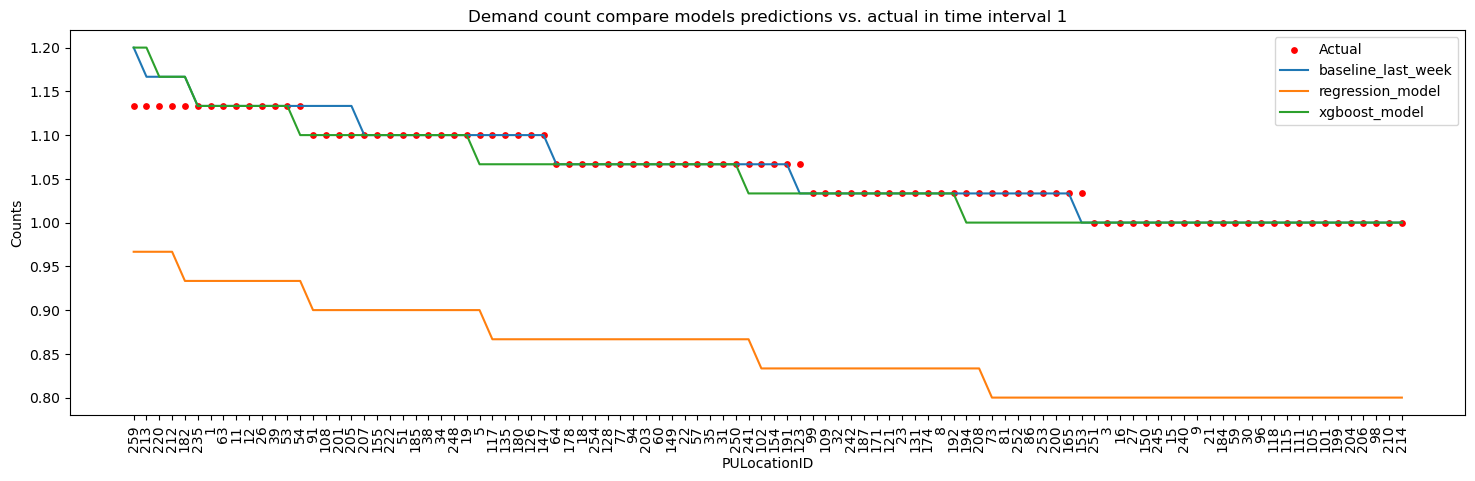

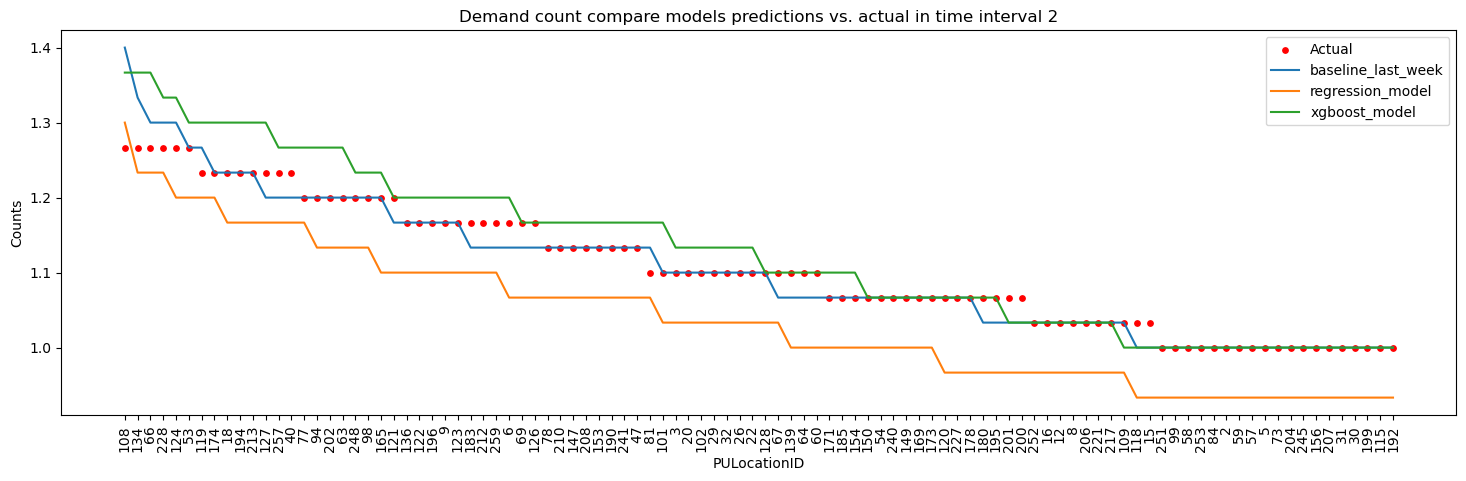

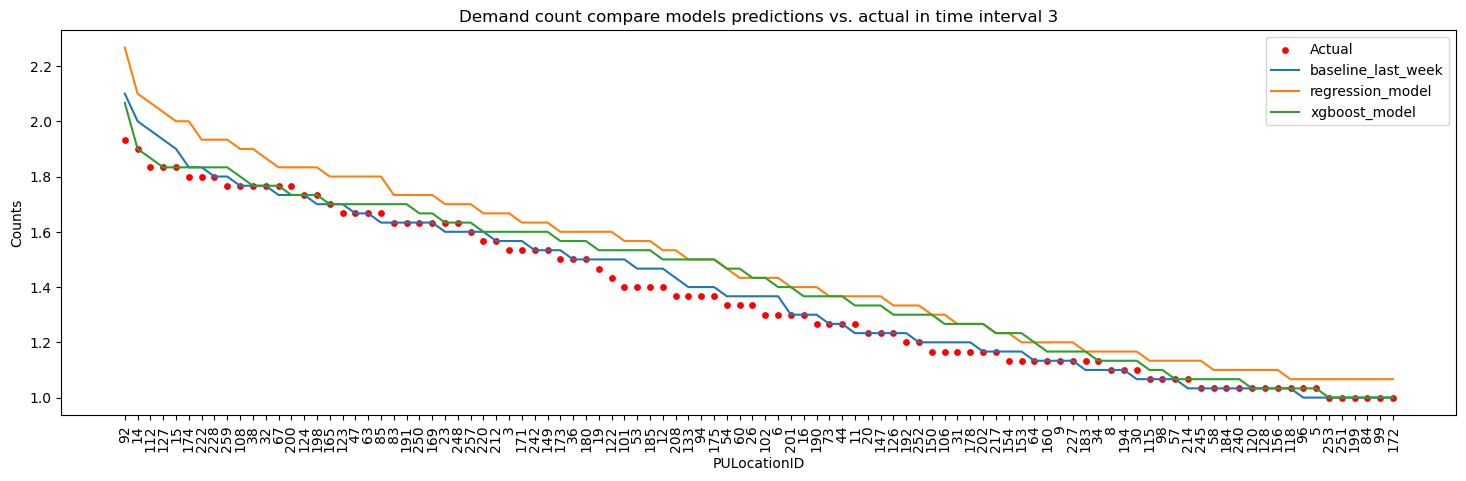

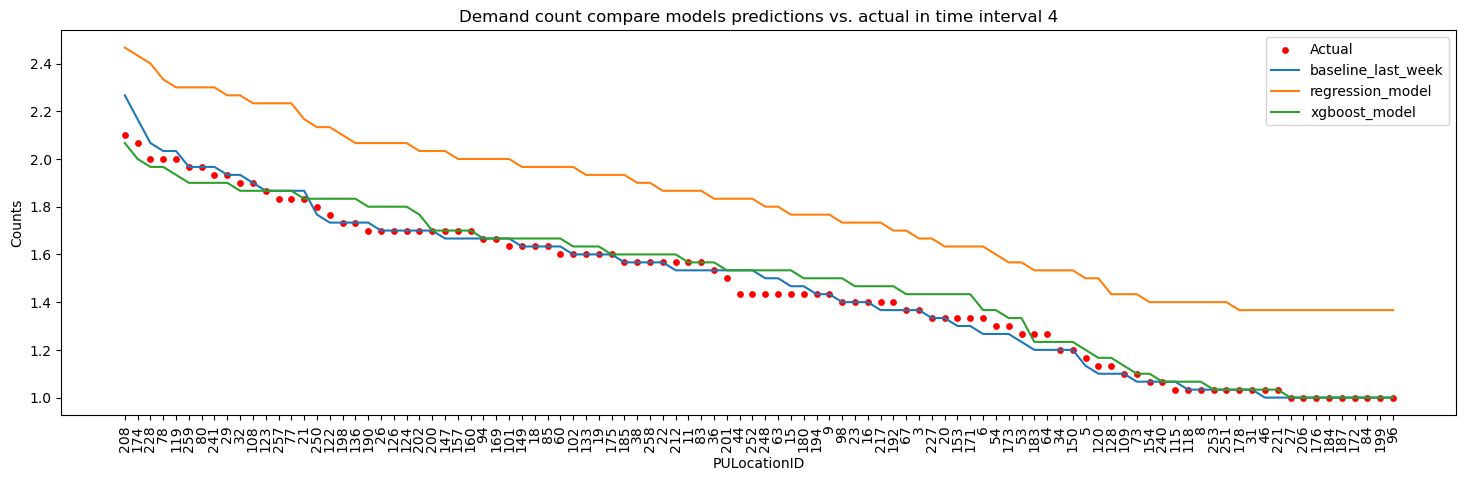

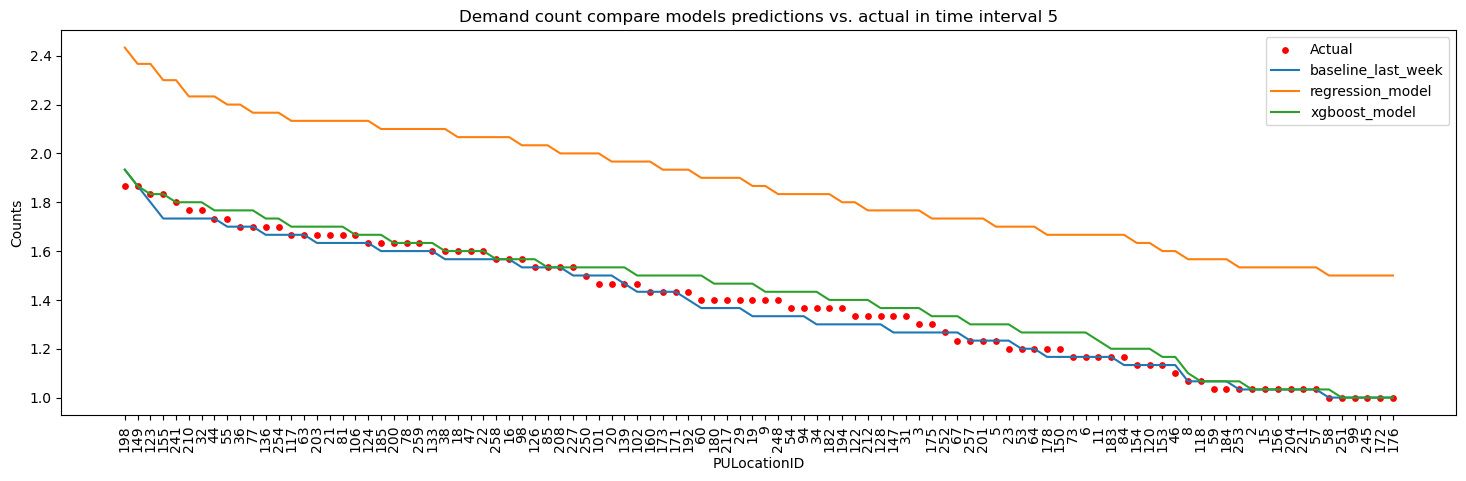

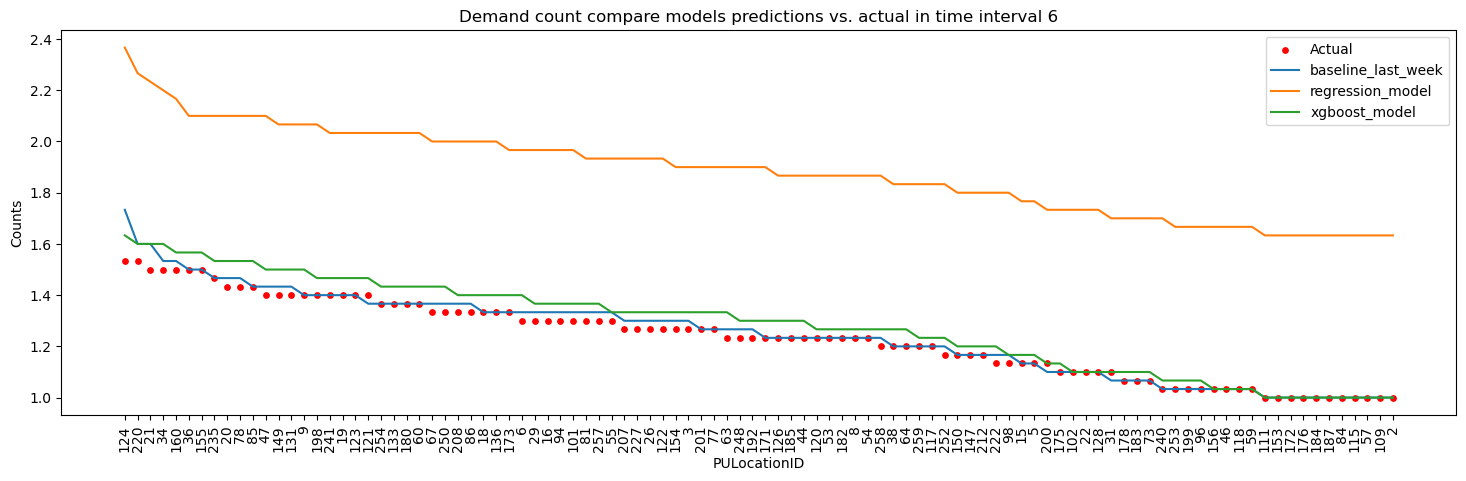

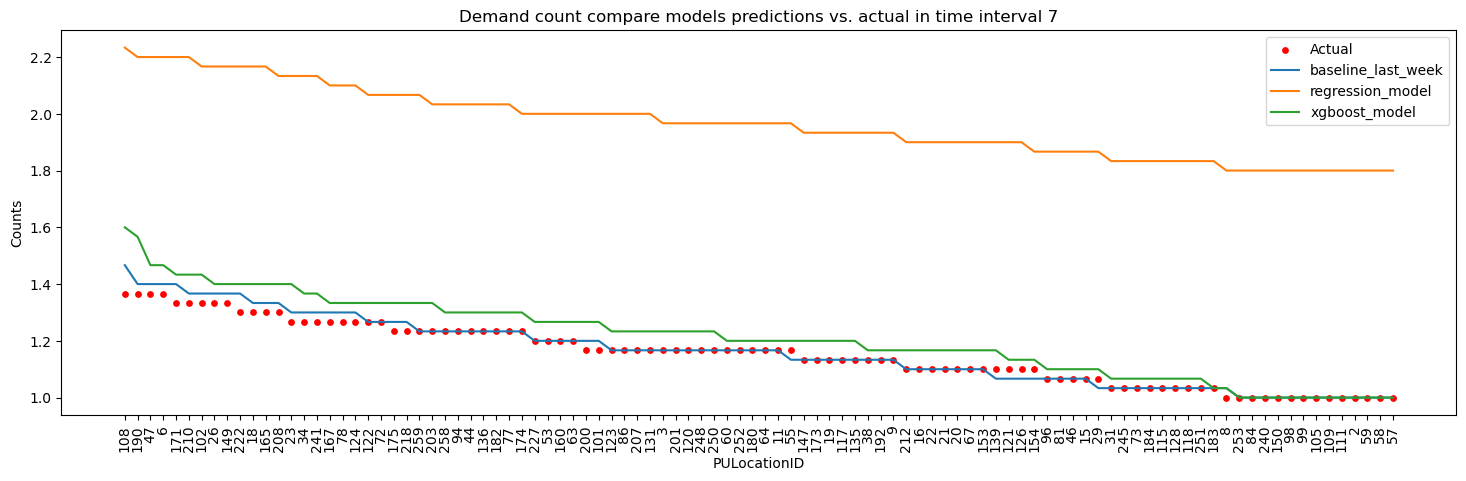

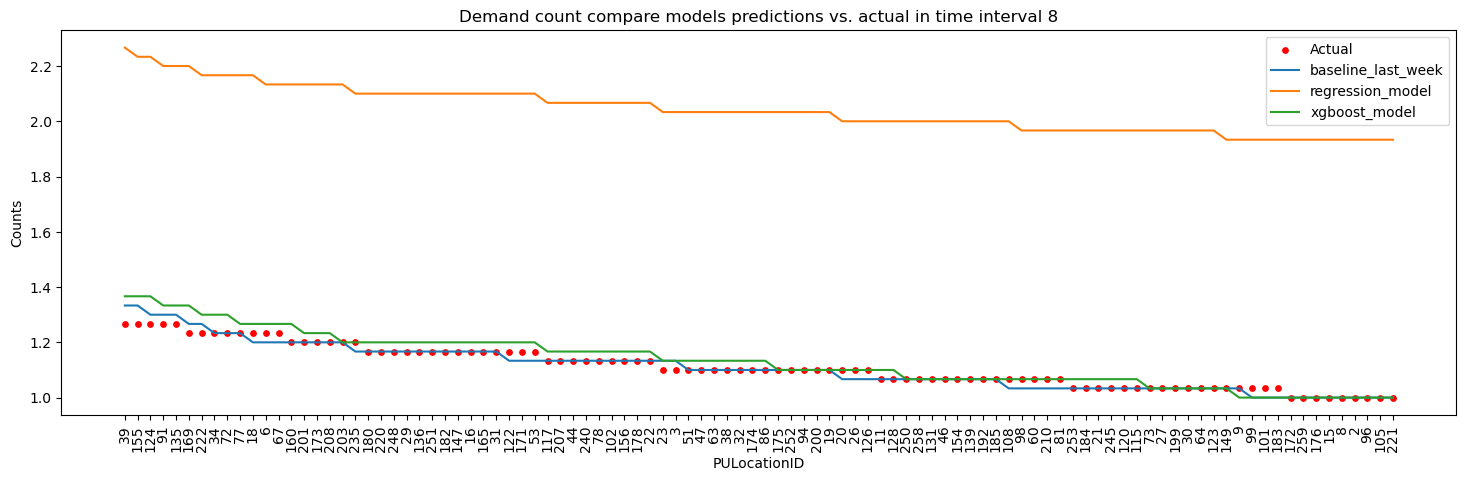

In [228]:
plot_separated_demand(predictions_dict, xgb_rides_df, 150, 250)

# Model prediction results in metrics

Metrics: MAPE, MAE, RMSE

In [229]:
def calculate_metrics(df, sorted_df, lower = 0, upper = 266):
    PULocationIDs_Metrics_Selected = sorted_df[
        sorted_df['PULocationID'].isin(df.iloc[lower:upper, 0])
    ]
    PULocationIDs_Metrics_Selected = PULocationIDs_Metrics_Selected.copy()
    PULocationIDs_Metrics_Selected['PULocationID'] = PULocationIDs_Metrics_Selected['PULocationID'].astype('str')
    predictions_result = []
    for key in predictions_dict:
        metric_mape = PULocationIDs_Metrics_Selected[
            PULocationIDs_Metrics_Selected['Model'] == key
        ]['MAPE'].mean()
        metric_mae = PULocationIDs_Metrics_Selected[
            PULocationIDs_Metrics_Selected['Model'] == key
        ]['MAE'].mean()
        metric_rmse = PULocationIDs_Metrics_Selected[
            PULocationIDs_Metrics_Selected['Model'] == key
        ]['RMSE'].mean()
        predictions_result.append(
            {
                'Model' : key,
                f"MAPE_{lower}-{upper}" : metric_mape,
                f"MAE_{lower}-{upper}" : metric_mae,
                f"RMSE_{lower}-{upper}" : metric_rmse
            }
        )
    return predictions_result

In [230]:
high_demand_df = {}
mid_demand_df = {}
low_demand_df = {}

def split_by_demand(lower_bound, upper_bound,interval):
  df = pd.DataFrame()
  df = df.append(
    pd.DataFrame(
        calculate_metrics(
            xgb_rides_df_sorted[interval],
            PULocationIDs_Metrics_sorted[interval],
            lower_bound,
            upper_bound
        )
    )
  )
  return df

for interval in range(1, 9):
    high_demand_df[interval] = split_by_demand(0, 50, interval)
    mid_demand_df[interval] = split_by_demand(50, 150, interval)
    low_demand_df[interval] = split_by_demand(150, 250, interval)

Merging all the results together and sort them

In [231]:
merged_result_df = {}
for interval in range(1, 9):
    merged_result_df[interval] = high_demand_df[interval].merge(
        mid_demand_df[interval],
        on = 'Model'
    ).merge(
        low_demand_df[interval],
        on = 'Model'
    )

Defining a custom sorting function to extract the numeric suffix and sort the columns accordingly

In [232]:
def sort_columns_key(column):
    if column == 'Model':
        return (0, '')
    metric, suffix = column.split('_')
    return (
        1,
        metric,
        int(suffix.split('-')[0]),
        int(suffix.split('-')[1])
    )

for interval in range(1, 9):
    sorted_columns = sorted(
        merged_result_df[interval].columns,
        key = sort_columns_key
    )
    predictions_result = merged_result_df[interval][sorted_columns]
    display(f"interval: {interval}",predictions_result)

'interval: 1'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  30.442000    1.523000     0.113333   0.323490   
1    regression_model  31.778000    1.788000     0.771667   0.462640   
2       xgboost_model  25.674667    1.406667     0.103667   0.316378   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.476419      0.084556  45.911042     2.221023      0.303987  
1     0.719957      0.733056  44.490078     2.382084      0.930059  
2     0.449145      0.075389  37.452108     1.998748      0.279268

'interval: 2'

Model  MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  9.334000    1.126667     0.181667   0.335849   
1    regression_model  9.616667    1.356333     0.686333   0.432975   
2       xgboost_model  9.146000    1.025333     0.200333   0.353161   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.515301      0.131444  13.148099     1.623122      0.400094  
1     0.719246      0.630778  12.970547     1.786168      0.903146  
2     0.488644      0.152333  12.915358     1.454765      0.404720

'interval: 3'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  23.111333    2.038667     0.474667   0.183387   
1    regression_model  21.760000    2.039333     0.899667   0.177865   
2       xgboost_model  20.928667    1.822000     0.434000   0.177925   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.575691      0.317439  29.739319     2.710098      0.763304  
1     0.629297      0.749933  28.335528     2.653475      1.139348  
2     0.511753      0.310717  27.686394     2.396757      0.685988

'interval: 4'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  31.905333    2.446333     0.580333   0.122617   
1    regression_model  29.011333    2.426000     0.980333   0.112672   
2       xgboost_model  28.730000    2.177333     0.536000   0.112923   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.594248      0.372521  39.664575     3.268323      0.902268  
1     0.660256      0.781894  36.281107     3.194438      1.309320  
2     0.520263      0.365305  36.023383     2.879665      0.804731

'interval: 5'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  36.934000    2.537667     0.536000   0.114408   
1    regression_model  33.703333    2.595667     1.036333   0.105962   
2       xgboost_model  32.548667    2.266333     0.508667   0.103846   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.596109      0.357411  46.111106     3.316909      0.838024  
1     0.724374      0.874772  42.331254     3.313848      1.341241  
2     0.528279      0.360306  41.173601     2.943187      0.761088

'interval: 6'

Model  MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week    46.022    2.563667     0.374667   0.131408   
1    regression_model    42.182    2.628000     1.063333   0.122521   
2       xgboost_model    42.574    2.253000     0.382000   0.121324   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.562959      0.268956  57.520645     3.433023      0.644611  
1     0.744577      0.965372  52.575376     3.441399      1.366470  
2     0.491515      0.286828  52.998472     2.976569      0.610985

'interval: 7'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  58.655333    2.489000     0.266000   0.165961   
1    regression_model  54.371333    2.639667     0.927667   0.158464   
2       xgboost_model  51.447333    2.172000     0.282667   0.151081   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.573641      0.191667  73.374673     3.268993      0.537327  
1     0.843989      0.873544  67.442464     3.370869      1.300382  
2     0.516485      0.218600  64.527261     2.817329      0.522545

'interval: 8'

Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  53.370667    2.166667     0.195667   0.195925   
1    regression_model  52.301333    2.416667     1.002667   0.203951   
2       xgboost_model  48.827333    1.903000     0.212333   0.189447   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.540384      0.140283  69.090997     2.916264      0.455274  
1     0.888276      0.965972  66.488028     3.105332      1.302821  
2     0.489063      0.159672  62.399219     2.552147      0.453572

In [233]:
tmp_df=pd.DataFrame.from_dict(merged_result_df[1])
for i in range(2,9):
    res=pd.DataFrame.from_dict(merged_result_df[i])
    tmp_df=pd.concat([tmp_df,res])

In [234]:
sorted_columns = sorted(
    tmp_df.columns,
    key = sort_columns_key
)
predictions_result = tmp_df[sorted_columns]
#display(predictions_result)
total=pd.DataFrame()
total['Model']=pd.DataFrame(predictions_result['Model'].unique())
for j in predictions_result.columns[:0:-1]:
    total=pd.merge(pd.DataFrame(predictions_result.groupby(['Model'])[j].mean()),
    total,
    on='Model'
    )

total


Model   MAE_0-50  MAE_50-150  MAE_150-250  MAPE_0-50  \
0  baseline_last_week  36.221833    2.111458     0.340292   0.196631   
1    regression_model  34.340500    2.236208     0.921000   0.222131   
2       xgboost_model  32.484583    1.878208     0.332458   0.190761   

   MAPE_50-150  MAPE_150-250  RMSE_0-50  RMSE_50-150  RMSE_150-250  
0     0.554344      0.233035  46.820057     2.844719      0.605611  
1     0.741246      0.821915  43.864298     2.905952      1.199098  
2     0.499393      0.241144  41.896974     2.502396      0.565362